## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib import cm
import os
import csv
import warnings
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import tensorflow.compat.v1 as tf

warnings.filterwarnings('ignore')

## Import individual ZLP spectra

Outputs: file1, file2, ... file13

<Figure size 432x288 with 0 Axes>

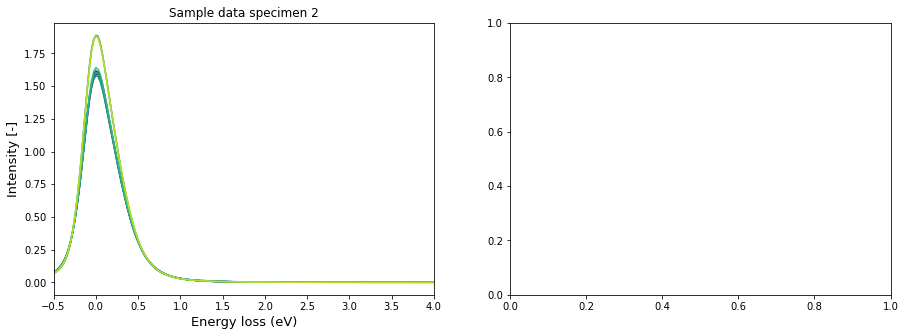

In [2]:
%run EELS-ZLP-Sabrya.py


## Create pd.DataFrames for vacuum and sample spectra

Column names: ['x', 'y', 'x_shifted', 'y_norm', 'log_y'] <br>

* x_shifted is the shifted spectrum s.t. $I_{max}$ is at $\Delta$E=0<br>
* y_norm is the normalized spectrum s.t. the total area under the curve = 1.

In [3]:
df_vacuum = pd.concat((file17, file22, file23))
df_vacuum = df_vacuum.sort_values('x').reset_index().drop('index', axis=1).dropna()

df = pd.concat((file14, file15, file16, file19, file20, file21))
df = df.sort_values('x').reset_index().drop('index', axis=1)

df['log_y'] = np.log(df['y'])

Use [x_shifted, y_norm] values of all the spectra as training inputs

In [4]:
x14, y14 = file14['x_shifted'], file14['y_norm']
x15, y15 = file15['x_shifted'], file15['y_norm']
x16, y16 = file16['x_shifted'], file16['y_norm']
x17, y17 = file17['x_shifted'], file17['y_norm']
x19, y19 = file19['x_shifted'], file19['y_norm']
x20, y20 = file20['x_shifted'], file20['y_norm']
x21, y21 = file21['x_shifted'], file21['y_norm']
x22, y22 = file22['x_shifted'], file22['y_norm']
x23, y23 = file23['x_shifted'], file23['y_norm']

In [5]:
%run Functions.ipynb

## Derivatives
In order to determine the values for $\Delta$E$_1$ and $\Delta$E$_2$, we calculate the derivatives of the intensity of each spectrum with respect to the change energy loss. We use the function 'smooth(y, window_len)' to smooth the functions and reveal underlying trends.

### In-sample

In [6]:
wl1 = 50
wl2 = 100

window_len = wl1
df_dx = pd.DataFrame({"x14": x14, "x15": x15, "x16": x16, "x17": x17, "x19": x19,\
                      "x20":x20, "x21":x21, "x22":x22, "x23": x23, \
                      "y14": smooth(y14, window_len), "y15": smooth(y15, window_len), \
                      "y16": smooth(y16, window_len), \
                      "y17": smooth(y17, window_len), "y19": smooth(y19, window_len), \
                      "y20": smooth(y20, window_len), "y21": smooth(y21, window_len), \
                      "y22": smooth(y22, window_len), "y23": smooth(y23, window_len)})
window_len = wl2

for i in ([14,15,16,17,19,20,21,22,23]):
    df_dx['log y%(i)s' %{"i": i}] = np.log(df_dx['y%(i)s'% {"i": i}])
    df_dx['derivative y%(i)s' %{"i": i}] = np.divide(df_dx['y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['smooth derivative y%(i)s' %{"i": i}] = smooth(df_dx['derivative y%(i)s' %{"i": i}], window_len)
    df_dx['log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['smooth log derivative y%(i)s' %{"i": i}] = smooth(df_dx['log derivative y%(i)s' %{"i": i}], window_len)
    df_dx['2nd derivative y%(i)s' %{"i": i}] = np.divide(df_dx['smooth derivative y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['2nd log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['smooth log derivative y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())   

Determine the first crossing with zero of the in-sample derivatives (dE$_{max}$):

In [7]:
li = []

for i in ([14,15,16,17,19,20,21,22,23]):
    crossing = df_dx[(df_dx['log derivative y%(i)s' %{"i": i}] > 0) & (df_dx['x%(i)s'% {"i": i}] > 1)]['x%(i)s'% {"i": i}].min()
    li.append(crossing)
    
dE1 = min(li)
dE1_max = np.round(dE1, 2)
print("The value of dE1 is", dE1_max)


The value of dE1 is 2.65


### In-vacuum

## Create plot of the derivatives

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


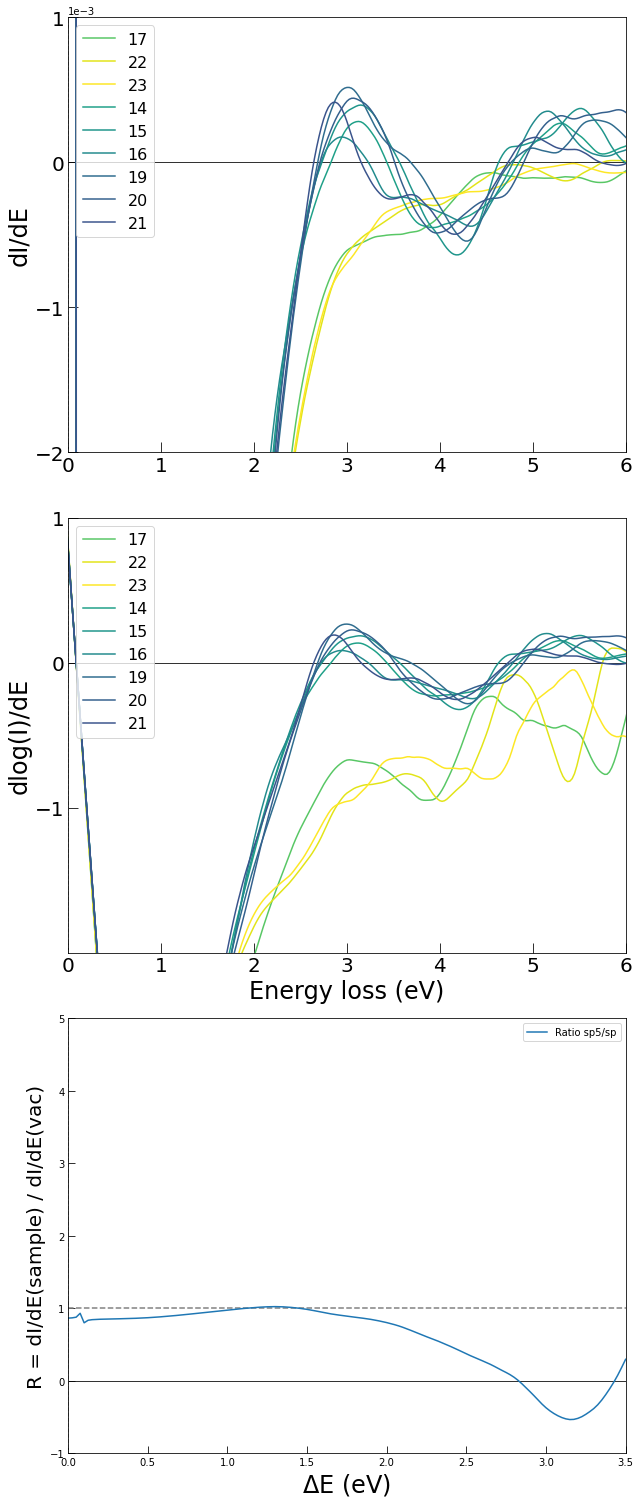

In [8]:
nrows, ncols = 3,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

cm_subsection = np.linspace(0,1,24) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})
          
for i in range(3):
    ax = plt.subplot(gs[i])
    ax.set_xlim([0,9])
    ax.tick_params(which='major',direction='in',length=7)
    ax.tick_params(which='minor',length=8)
    plt.axhline(y=0, color='black', linewidth=1, alpha=.8)
    plt.axvline(x=0, color='darkgray', linestyle='--', linewidth = 1)
    #plt.axvline(x=dE1, color='darkgray', linestyle='--', linewidth = 1, label='$\Delta$E1' %{'s': dE1})
    
    for j in ([17, 22, 23]):
        if i == 0:
            p2 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['derivative y%(i)s' %{"i": j}], color=colors[j], label='%(i)s' %{"i": j})
            
        if i == 1: 
            p2 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['log derivative y%(i)s' %{"i": j}], color=colors[j], label='%(i)s' %{"i": j})     
    
    for j in ([14,15,16,19,20,21]):
        k = j-3
        
        if i == 0:
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['derivative y%(i)s' %{"i": j}], color=colors[-k], label='%(i)s' %{"i": j})
            ax.set_ylim([-.002, .001])
            ax.set_xlim([0, 6])
            ax.set_ylabel('dI/dE',fontsize=24)
            ax.set_yticks([-0.002, -0.001, 0, 0.001])
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax.legend(loc=2, fontsize=16)
        if i == 1:
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['log derivative y%(i)s' %{"i": j}], color=colors[-k],label='%(i)s' %{"i": j})
            ax.set_ylim([-2, 1])
            ax.set_xlim([0, 6])
            ax.set_ylabel('dlog(I)/dE',fontsize=24)
            ax.set_yticks([-1, 0, 1])
            ax.legend(loc=2, fontsize=16)
        
    for j in ([14]):   
        if i == 2: 
            ax.axhline(y=1, linestyle='--', color='gray')
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}], np.divide(df_dx['derivative y%(i)s'% {"i": j}],df_dx['derivative y22']), label='Ratio sp5/sp'%{"i":j})
            ax.set_ylim([-1, 5])
            ax.set_xlim([0,3.5])   
            ax.set_ylabel('R = dI/dE(sample) / dI/dE(vac)', fontsize=20)
            ax.set_xlabel('$\Delta$E (eV)', fontsize=24)
            ax.legend()  
    
    if i == 0:
        ax.tick_params(labelbottom=True)
        ax.tick_params(which='major', length= 10, labelsize=20)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    if i == 1:
        ax.set_xlabel('Energy loss (eV)', fontsize=24)
        ax.tick_params(length= 10, labelsize=18)
        ax.tick_params(which='major', length= 10, labelsize=20)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    
plt.tight_layout()
plt.savefig("Derivatives.pdf")
plt.show()

## dE1 and dE2

The value of dE$_{max}$ was calculated as the first time the derivative dI/dE crosses zero.<br>
We train the neural network until a maximum energy loss, which we call dE1. 

In [9]:
dE1 = 1.65
dE2 = 8

print('The values of dE1 and dE2', dE1, dE2)

The values of dE1 and dE2 1.65 8


## Window and prepare data
* Drop all data for $\Delta$E $> \Delta$E$_1$
* Calculate the binned mean and variance of the spectra together with the function 'binned_statistics(x,y,nbins)'
* Returns two pd.DataFrames 'df_mean' and 'df_vacmean' with the mean and variance data of the in-sample and in-vacuum spectra



In [10]:
df_window = df[(df['x_shifted'] < dE1) & (df['x_shifted'] > -.5)]
df_window_vacuum = df_vacuum[(df_vacuum['x_shifted'] <= dE1) & (df_vacuum['x_shifted'] > -.5)]

df_mean, df_vacmean = pd.DataFrame(), pd.DataFrame()
nbins = 32

df_mean['x'] = np.linspace(df_window['x_shifted'].min(),df_window['x_shifted'].max(), nbins)
df_mean['y'], df_mean['sigma'] = binned_statistics(df_window['x_shifted'], np.log(df_window['y']), nbins)[0:2]

df_vacmean['x'] = np.linspace(df_window_vacuum['x_shifted'].min(),df_window_vacuum['x_shifted'].max(), nbins)
df_vacmean['y'], df_vacmean['sigma'] = binned_statistics(df_window_vacuum['x_shifted'], np.log(df_window_vacuum['y']), nbins)[0:2]



### Create pseudo data for $\Delta$E $ > \Delta$E$_2$

In [17]:
min_x = dE2
max_x = 12
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': .5 * np.ones(N_pseudo), \
                    'sigma': .08 * np.ones(N_pseudo)})

df_full = pd.concat([df_mean, df_pseudo])

df_mean.describe()

,x,y,sigma
count,32.000000,32.000000,32.000000
mean,0.562500,12.049793,0.079412
std,0.643041,1.902914,0.033633
min,-0.500000,8.897154,0.026075
25%,0.031250,10.374057,0.055802
50%,0.562500,12.212578,0.071512
75%,1.093750,13.833910,0.097188
max,1.625000,14.659557,0.175602


### Create architecture

In [18]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [19]:
tf.compat.v1.get_default_graph
tf.compat.v1.disable_eager_execution()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value
df_train, df_test = train_test_split(df_train_full, test_size=0.2)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = (np.copy(df_train['y'])).reshape(N_train,1)
train_sigma = (np.copy(df_train['sigma'])).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = (np.copy(df_test['y'])).reshape(N_test,1)
test_sigma = (np.copy(df_test['sigma'])).reshape(N_test,1)

predictions = make_model(x,1)
N_pred = 30000
predict_x = np.linspace(-.3,12,N_pred).reshape(N_pred,1)

#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
train_sigma.shape

(49, 1)

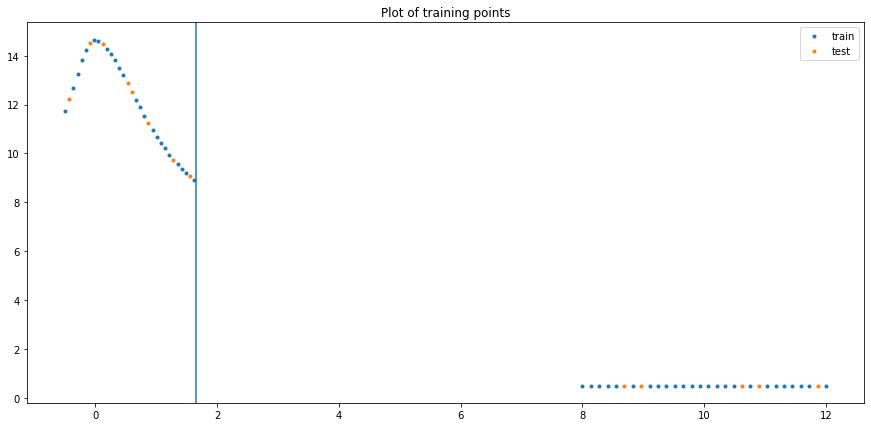

In [20]:
plt.figure(figsize=(15,7))
#plt.xlim([-0.35, -0.2])
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.axvline(x=1.65)
plt.title('Plot of training points')
plt.legend()

## Create MC replicas

In [21]:
Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

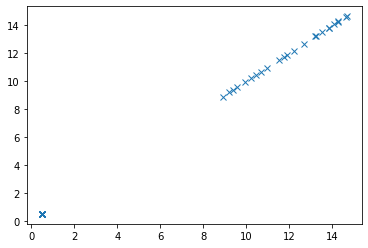

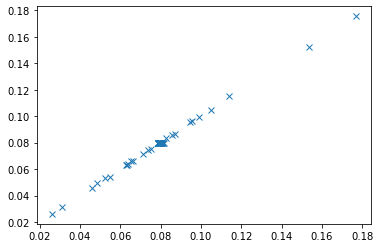

In [22]:
plt.plot(mean_reps, train_y,'x')
plt.show()
plt.plot(std_reps, train_sigma,'x')
plt.show()

In [23]:
import time
from datetime import datetime
now = datetime.now()


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 5e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 100

    for i in range(Nrep):

        train_y = train_y_reps[:, i*4 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i*4 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 25000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            


            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = now.strftime("%d.%m.%Y")
            t_string = now.strftime("%H:%M:%S")
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s_x2_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/Sabrya/%(date)s/x2_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i+10 }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/Sabrya/%(date)s/x2_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Sabrya/%(date)s/x2_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Parallel training

In [24]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=4
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4])

pool.close()

#print(pool)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
processor2 starts training onprocessor4 starts training on  0049processor1 starts training on 00490049 and validating on  0013  samples
and validating onprocessor3 starts training onand validating on   00130013 0049  samplesand validating onsamples

 0013 samples
Epoch:Epoch:Epoch:   00010001 0001  | Training cost=| Training cost=| Training cost=Epoch:    19647.02539062519648.457031250 19627.9433593750001| Validation cost=    15206.644531250| Validation cost=| Validation cost=| Training cost=
   19692.94335937515316.341796

Epoch: 22001 | Training cost= 2.360180140 | Validation cost= 3.987335205
Epoch: 22001 | Training cost= 2.324120283 | Validation cost= 2.029724598
Epoch: 22001 | Training cost= 3.010297775 | Validation cost= 1.775366306
Epoch: 23001 | Training cost= 2.524964571 | Validation cost= 2.159801006
Epoch: 23001 | Training cost= 2.454041719 | Validation cost= 3.907170773
Epoch: 23001 | Training cost= 1.554922104 | Validation cost= 1.399363756
Epoch: 23001 | Training cost= 2.654441118 | Validation cost= 1.696865082
Epoch: 24001 | Training cost= 2.233069897 | Validation cost= 1.920161009
Epoch: 24001 | Training cost= 2.402642250 | Validation cost= 3.831789494
Epoch: 24001 | Training cost= 2.212016344 | Validation cost= 1.964428186
Epoch: 24001 | Training cost= 2.568034172 | Validation cost= 1.611059785
Optimization 0 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Optimization 0 Finished! Best model after epoch 24000
INFO:tens

Epoch: 23001 | Training cost= 2.117128849 | Validation cost= 3.155100346
Epoch: 23001 | Training cost= 1.699876070 | Validation cost= 2.568705082
Epoch: 23001 | Training cost= 22.981079102 | Validation cost= 18.003963470
Epoch: 24001 | Training cost= 1.930354834 | Validation cost= 2.656969547
Epoch: 24001 | Training cost= 2.094638586 | Validation cost= 3.155415535
Epoch: 24001 | Training cost= 1.680987120 | Validation cost= 2.519858360
Epoch: 24001 | Training cost= 22.968040466 | Validation cost= 18.006177902
Optimization 1 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Optimization 1 Finished! Best model after epoch 23000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-23000
Optimization 1 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Optimization 1 Finished! Best model after epoch 17000
INFO:tensorflow:Restoring par

Epoch: 24001 | Training cost= 2.195548773 | Validation cost= 2.765523434
Epoch: 24001 | Training cost= 2.244337320 | Validation cost= 2.799478292
Epoch: 24001 | Training cost= 1.959159255 | Validation cost= 1.496839046
Optimization 2 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Optimization 2 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Optimization 2 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-24000
Epoch: 0001 | Training cost= 23457.664062500 | Validation cost= 19309.482421875
Optimization 2 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-24000
Epoch: 0001Epoch:  | Training cost=0001  23507.558593750| Training cost=  23501.806640625| Validation cost= | Validation cost=  19247.63281250019257.820312500

Epoch

Epoch: 23001 | Training cost= 8073.162597656 | Validation cost= 5799.254882812
Epoch: 23001 | Training cost= 8095.753417969 | Validation cost= 5738.744628906
Epoch: 24001 | Training cost= 8073.929687500 | Validation cost= 5800.962890625
Epoch: 24001 | Training cost= 8088.118164062 | Validation cost= 5801.539550781
Epoch: 24001 | Training cost= 8073.162597656 | Validation cost= 5799.254882812
Epoch: 24001 | Training cost= 8095.753417969 | Validation cost= 5738.745117188
Optimization 3 Finished! Best model after epoch 2000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-2000
Optimization 3 Finished! Best model after epoch 2000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-2000
Optimization 3 Finished! Best model after epoch 6000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-6000
Epoch: 0001 | Training cost= 32219.822265625 | Validation cost= 25808.847656250
Optimization 3 Finished! Best model after epoch 20

Epoch: 24001 | Training cost= 2.075643778 | Validation cost= 1.171175003
Epoch: 24001 | Training cost= 1.676627278 | Validation cost= 3.820041895
Optimization 4 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Optimization 4 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Optimization 4 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-24000
Optimization 4 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-24000
Epoch: 0001 | Training cost= 22259.265625000 | Validation cost= 18219.068359375
Epoch: 0001 | Training cost= 22267.177734375 | Validation cost= 18083.154296875
Epoch: 0001 | Training cost= 22183.599609375 | Validation cost= 18285.226562500
Epoch: 0001 | Training cost= 22229.916015625 | Validation cost= 18289.03320312

Epoch: 0001 | Training cost= Optimization 5 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-24000
22493.519531250 | Validation cost= 18286.945312500
Optimization 5 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-24000
Epoch: 0001 | Training cost= 22531.025390625 | Validation cost= 18439.271484375
Epoch: 0001 | Training cost= 22544.546875000 | Validation cost= 18362.531250000
Epoch: 0001 | Training cost= 22546.630859375 | Validation cost= 18480.490234375
Epoch: 1001 | Training cost= 39.463592529 | Validation cost= 39.881130219
Epoch: 1001 | Training cost= 40.917110443 | Validation cost= 46.694389343
Epoch: 1001 | Training cost= 39.826698303 | Validation cost= 37.556118011
Epoch: 1001 | Training cost= 42.632720947 | Validation cost= 43.647235870
Epoch: 2001 | Training cost= 18.648319244 | Validation cost= 18.754451752
Epoch: 2001 | Training cost= 17.308937073 

Epoch: 0001 | Training cost= 21971.861328125 | Validation cost= 18141.271484375
Epoch: 0001 | Training cost= 21925.703125000 | Validation cost= 18213.898437500
Epoch: 0001 | Training cost= 22046.531250000 | Validation cost= 18043.039062500
Epoch: 1001 | Training cost= 36.458972931 | Validation cost= 39.906562805
Epoch: 1001 | Training cost= 33.222824097 | Validation cost= 33.972080231
Epoch: 1001 | Training cost= 34.034992218 | Validation cost= 28.817012787
Epoch: 1001 | Training cost= 34.097381592 | Validation cost= 35.769523621
Epoch: 2001 | Training cost= 26.809734344 | Validation cost= 27.856294632
Epoch: 2001 | Training cost= 24.308828354 | Validation cost= 22.775053024
Epoch: 2001 | Training cost= 24.852947235 | Validation cost= 19.618227005
Epoch: 2001 | Training cost= 24.954124451 | Validation cost= 24.940076828
Epoch: 3001 | Training cost= 25.559116364 | Validation cost= 26.374063492
Epoch: 3001 | Training cost= 23.087526321 | Validation cost= 21.348218918
Epoch: 3001 | Traini

Epoch: 0001 | Training cost= 23141.515625000 | Validation cost= 18545.121093750
Epoch: 1001 | Training cost= 21.458669662 | Validation cost= 23.726139069
Epoch: 1001 | Training cost= 23.185104370 | Validation cost= 23.388990402
Epoch: 1001 | Training cost= 22.119533539 | Validation cost= 17.367759705
Epoch: 1001 | Training cost= 21.646865845 | Validation cost= 26.775978088
Epoch: 2001 | Training cost= 10.325647354 | Validation cost= 13.163243294
Epoch: 2001 | Training cost= 9.628919601 | Validation cost= 12.313899040
Epoch: 2001 | Training cost= 10.084617615 | Validation cost= 8.867863655
Epoch: 2001 | Training cost= 10.598356247 | Validation cost= 11.937225342
Epoch: 3001 | Training cost= 8.566142082 | Validation cost= 10.944397926
Epoch: 3001 | Training cost= 8.219810486 | Validation cost= 10.908784866
Epoch: 3001 | Training cost= 8.631311417 | Validation cost= 7.844747543
Epoch: 3001 | Training cost= 9.013407707 | Validation cost= 9.535475731
Epoch: 4001 | Training cost= 7.527633190

Epoch: 1001 | Training cost= 41.319515228 | Validation cost= 33.594295502
Epoch: 2001 | Training cost= 29.569793701 | Validation cost= 24.632629395
Epoch: 2001 | Training cost= 30.902345657 | Validation cost= 24.715671539
Epoch: 2001 | Training cost= 28.558542252 | Validation cost= 32.838378906
Epoch: 2001 | Training cost= 30.945589066 | Validation cost= 24.915525436
Epoch: 3001 | Training cost= 21.295110703 | Validation cost= 18.454801559
Epoch: 3001 | Training cost= 22.610847473 | Validation cost= 17.953739166
Epoch: 3001 | Training cost= 21.447868347 | Validation cost= 25.610553741
Epoch: 3001 | Training cost= 22.079425812 | Validation cost= 18.385433197
Epoch: 4001 | Training cost= 9.665752411 | Validation cost= 9.661536217
Epoch: 4001 Epoch:| Training cost= 4001  10.381749153| Training cost= | Validation cost=  11.571309090 8.007305145
| Validation cost= 14.660773277
Epoch: 4001 | Training cost= 10.180992126 | Validation cost= 9.220015526
Epoch: 5001 | Training cost= 7.140901089 |

Epoch: 2001 | Training cost= 23.487892151 | Validation cost= 33.468196869
Epoch: 3001 | Training cost= 8.617173195 | Validation cost= 7.102798462
Epoch: 3001 | Training cost= Epoch:9.123430252  | Validation cost=3001  | Training cost= 11.6880588539.253404617
 | Validation cost= 11.477039337
Epoch: 3001 | Training cost= 9.467556000 | Validation cost= 12.416952133
Epoch: 4001 | Training cost= 7.034602165 | Validation cost= 6.040724754
Epoch: Epoch: 40014001  | Training cost=| Training cost=  7.633534908 7.356577873| Validation cost= | Validation cost=  9.682947159
10.390508652
Epoch: 4001 | Training cost= 7.712344646 | Validation cost= 9.592968941
Epoch: 5001 | Training cost= 5.911914349 | Validation cost= 5.202651501
Epoch: 5001 | Training cost= 6.378197670 | Validation cost= 8.995978355
Epoch: 5001 | Training cost= 6.802808285 | Validation cost= 8.573486328
Epoch: 5001 | Training cost= 6.683654308 | Validation cost= 8.414044380
Epoch: 6001 | Training cost= 4.935760498 | Validation cost

Epoch: 3001 | Training cost= 22.430435181 | Validation cost= 25.725240707
Epoch: 4001 | Training cost= 21.617828369 | Validation cost= 22.530183792
Epoch: 4001 | Training cost= 23.917467117 | Validation cost= 20.824514389
Epoch: 4001 | Training cost= 23.847866058 | Validation cost= 23.230140686
Epoch: 4001 | Training cost= 21.728313446 | Validation cost= 25.557271957
Epoch: 5001 | Training cost= 21.485130310 | Validation cost= 22.333789825
Epoch: 5001 | Training cost= 23.700685501 | Validation cost= 20.648120880
Epoch: 5001 | Training cost= 23.632307053 | Validation cost= 22.855133057
Epoch: 5001 | Training cost= 21.516651154 | Validation cost= 25.568284988
Epoch: 6001 | Training cost= 21.423995972 | Validation cost= 22.271009445
Epoch: 6001 | Training cost= 23.585367203 | Validation cost= 20.565509796
Epoch: 6001 | Training cost= 23.516128540 | Validation cost= 22.732570648
Epoch: 6001 | Training cost= 21.420011520 | Validation cost= 25.536344528
Epoch: 7001 | Training cost= 21.379093

Epoch: 4001 | Training cost= 8084.293457031 | Validation cost= 5765.856933594
Epoch: 4001 | Training cost= 8041.984863281 | Validation cost= 5816.856933594
Epoch: 4001 | Training cost= 8076.344238281 | Validation cost= 5804.836425781
Epoch: 4001 | Training cost= 8045.022949219 | Validation cost= 5765.831542969
Epoch: 5001 | Training cost= 8084.292968750 | Validation cost= 5765.856933594
Epoch: 5001 | Training cost= 8076.344238281 | Validation cost= 5804.836425781Epoch:
 5001 | Training cost= 8041.983886719 | Validation cost= 5816.856933594
Epoch: 5001 | Training cost= 8045.022949219 | Validation cost= 5765.831542969
Epoch: 6001 | Training cost= 8084.292968750 | Validation cost= 5765.856933594
Epoch: 6001 | Training cost= 8076.344238281 | Validation cost= 5804.836425781
Epoch: 6001 | Training cost= 8041.984863281 | Validation cost= 5816.856933594
Epoch: 6001 | Training cost= 8045.022949219 | Validation cost= 5765.831542969
Epoch: 7001 | Training cost= 8084.292968750 | Validation cost= 5

Epoch: 3001 | Training cost= 5.071664333 | Validation cost= 4.830334187
Epoch: 3001 | Training cost= 5.472038269 | Validation cost= 5.105446815
Epoch: 4001 | Training cost= 4.623009682 | Validation cost= 6.346724987
Epoch: 4001 | Training cost= 4.911327362 | Validation cost= 6.994280338
Epoch: 4001 | Training cost= 4.661780357 | Validation cost= 4.783781052
Epoch: 4001 | Training cost= 4.916274548 | Validation cost= 4.308419228
Epoch: 5001 | Training cost= 4.055007458 | Validation cost= 5.597558975
Epoch: 5001 | Training cost= 4.496237755 | Validation cost= 6.478346825
Epoch: 5001 | Training cost= 3.989193439 | Validation cost= 4.517096996
Epoch: 5001 | Training cost= 4.382468224 | Validation cost= 3.732625008
Epoch: 6001 | Training cost= 4.015719414 | Validation cost= 4.962025166
Epoch: 6001 | Training cost= 4.089197159 | Validation cost= 6.065215588
Epoch: 6001 | Training cost= 3.424996138 | Validation cost= 4.444624901
Epoch: 6001 | Training cost= 4.085837364 | Validation cost= 3.29

Epoch: 4001 | Training cost= 23.728879929 | Validation cost= 19.678739548
Epoch: 4001 | Training cost= 24.459838867 | Validation cost= 21.480760574
Epoch: 5001 | Training cost= 23.573972702 | Validation cost= 22.080993652
Epoch: 5001 | Training cost= 21.844894409 | Validation cost= 24.119655609
Epoch: 5001 | Training cost= 23.342634201 | Validation cost= 19.449306488
Epoch: 5001 | Training cost= 24.156167984 | Validation cost= 21.007272720
Epoch: 6001 | Training cost= 23.315828323 | Validation cost= 21.675649643
Epoch: 6001 | Training cost= 21.758058548 | Validation cost= 24.104154587
Epoch: 6001 | Training cost= 23.231126785 | Validation cost= 19.323989868
Epoch: 6001 | Training cost= 24.031290054 | Validation cost= 20.804588318
Epoch: 7001 | Training cost= 23.213108063 | Validation cost= 21.415477753
Epoch: 7001 | Training cost= 21.716001511 | Validation cost= 24.049173355
Epoch: 7001 | Training cost= 23.174625397 | Validation cost= 19.213657379
Epoch: 7001 | Training cost= 23.951425

Epoch: 5001 | Training cost= 9.589609146 | Validation cost= 11.982092857
Epoch: 5001 | Training cost= Epoch:9.455883026  5001| Validation cost=  | Training cost= 9.0135717399.754548073
 | Validation cost= 17.522951126
Epoch: 5001 | Training cost= 9.243584633 | Validation cost= 15.165100098
Epoch: 6001 | Training cost= 8.684407234 | Validation cost= 10.672731400
Epoch: 6001 Epoch:| Training cost=  60018.785931587  | Validation cost=| Training cost=  8.38379573815.597972870 
| Validation cost= 7.689066887
Epoch: 6001 | Training cost= 8.313871384 | Validation cost= 13.640995979
Epoch: 7001 | Training cost= 8.032672882 | Validation cost= 9.846235275
Epoch: 7001 | Training cost= 8.086352348 | Validation cost= 14.330728531
Epoch: 7001 | Training cost= 7.690407753 | Validation cost= 6.950960159
Epoch: 7001 | Training cost= 7.667490482 | Validation cost= 12.702800751
Epoch: 8001 | Training cost= 7.525372982 | Validation cost= 9.298950195
Epoch:Epoch: 8001  | Training cost= 7.1967401508001 | Va

Epoch: 1001 | Training cost= 35.099334717 | Validation cost= 42.443344116
Epoch: 1001 | Training cost= 34.460762024 | Validation cost= 36.283309937
Epoch: 2001 | Training cost= 19.705978394 | Validation cost= 24.216526031
Epoch: 2001 | Training cost= 19.667499542 | Validation cost= 19.000057220
Epoch: 2001 | Training cost= 20.601366043 | Validation cost= 25.703950882
Epoch: 2001 | Training cost= 20.833896637 | Validation cost= 20.534975052
Epoch: 3001 | Training cost= 7.382266998 | Validation cost= 10.233405113
Epoch: 3001 | Training cost= 7.185726166 | Validation cost=Epoch:  7.6251225473001
 | Training cost= 7.896209240 | Validation cost= 12.035334587
Epoch: 3001 | Training cost= 8.232834816 | Validation cost= 7.026657104
Epoch: 4001 | Training cost= 4.648202896 | Validation cost= 5.946220875
Epoch: 4001 | Training cost= 4.717705250 | Validation cost= 5.066460133
Epoch: 4001 | Training cost= 5.018268585 | Validation cost= 8.921545029
Epoch: 4001 | Training cost= 5.053472519 | Validat

Epoch: 2001 | Training cost= 32.232368469 | Validation cost= 31.832925797
Epoch: 2001 | Training cost= 35.373317719 | Validation cost= 40.017620087
Epoch: 3001 | Training cost= 29.086326599 | Validation cost= 23.968606949
Epoch: 3001 | Training cost= 29.461854935 | Validation cost= 26.271329880
Epoch: 3001 | Training cost= 13.226067543 | Validation cost= 14.364508629
Epoch: 3001 | Training cost= 28.762264252 | Validation cost= 31.922698975
Epoch: 4001 | Training cost= 27.803819656 | Validation cost= 22.433652878
Epoch: 4001 | Training cost= 27.509027481 | Validation cost= 24.710933685
Epoch: 4001 | Training cost= 6.514999866 | Validation cost= 7.061344624
Epoch: 4001 | Training cost= 25.458595276 | Validation cost= 28.127674103
Epoch: 5001 | Training cost= 26.030986786 | Validation cost= 21.986652374
Epoch: 5001 | Training cost= 26.305988312 | Validation cost= 23.823661804
Epoch: 5001 | Training cost= 5.185999393 | Validation cost= 5.838404179
Epoch: 5001 | Training cost= 24.757358551 

Epoch: 3001 | Training cost= 8056.194335938 | Validation cost= 5716.515625000
Epoch: 3001 | Training cost= 8102.033203125 | Validation cost= 5753.110351562
Epoch: 3001 | Training cost= 8056.297363281 | Validation cost= 5826.152832031
Epoch: 4001 | Training cost= 8066.563964844 | Validation cost= 5793.814453125
Epoch: 4001 | Training cost= 8056.194335938 | Validation cost= 5716.515625000
Epoch: 4001 | Training cost= 8102.033203125 | Validation cost= 5753.110351562
Epoch: 4001 | Training cost= 8056.297363281 | Validation cost= 5826.152832031
Epoch: 5001 | Training cost= 8066.564453125 | Validation cost= 5793.814453125
Epoch: 5001 | Training cost= 8056.194335938 | Validation cost= 5716.515625000
Epoch: 5001 | Training cost= 8102.033203125 | Validation cost= 5753.110351562
Epoch: 5001 | Training cost= 8056.297363281 | Validation cost= 5826.152832031
Epoch: 6001 | Training cost= 8066.563964844 | Validation cost= 5793.814453125
Epoch: 6001 | Training cost= 8056.194335938 | Validation cost= 5

Epoch: 2001 | Training cost= 47.451316833 | Validation cost= 46.879146576
Epoch: 2001 | Training cost= 48.050617218 | Validation cost= 52.345474243
Epoch: 3001 | Training cost= 40.320007324 | Validation cost= 49.776115417
Epoch: 3001 | Training cost= 37.083091736 | Validation cost= 45.363788605
Epoch: 3001 | Training cost= 39.363018036 | Validation cost= 37.406948090
Epoch: 3001 | Training cost= 38.675289154 | Validation cost= 39.794326782
Epoch: 4001 | Training cost= 28.707708359 | Validation cost= 33.103103638
Epoch: 4001 | Training cost= 25.623281479 | Validation cost= 31.465820312
Epoch: 4001 | Training cost= 27.229866028 | Validation cost= 25.241281509
Epoch: 4001 | Training cost= 27.525787354 | Validation cost= 25.387962341
Epoch: 5001 | Training cost= 26.705656052 | Validation cost= 30.603668213
Epoch: 5001 | Training cost= 23.153753281 | Validation cost= 28.686153412
Epoch: 5001 | Training cost= 25.324846268 | Validation cost= 23.421497345
Epoch: 5001 | Training cost= 26.055349

Epoch: 2001 | Training cost= 8053.280761719 | Validation cost= 5832.755371094
Epoch: 3001 | Training cost= 8059.809082031 | Validation cost= 5770.942871094
Epoch: 3001 | Training cost= 8060.831542969 | Validation cost= 5760.287109375
Epoch: 3001 | Training cost= 8047.782714844 | Validation cost= 5749.038574219
Epoch: 3001 | Training cost= 8053.280761719 | Validation cost= 5832.755371094
Epoch: 4001 | Training cost= 8059.809082031 | Validation cost= 5770.942871094
Epoch: 4001 | Training cost= 8060.831542969 | Validation cost= 5760.287109375
Epoch: 4001 | Training cost= 8047.783203125 | Validation cost= 5749.038574219
Epoch: 4001 | Training cost= 8053.280761719 | Validation cost= 5832.755371094
Epoch: 5001 | Training cost= 8059.809082031 | Validation cost= 5770.942871094
Epoch: 5001 | Training cost= 8060.831542969 | Validation cost= 5760.287109375
Epoch: 5001 | Training cost= 8047.782714844 | Validation cost= 5749.038574219
Epoch: 5001 | Training cost= 8053.280761719 | Validation cost= 5

Epoch: 2001 | Training cost= 28.325330734 | Validation cost= 19.810981750
Epoch: 2001 | Training cost=Epoch: 2001 | Training cost= 29.010799408  | Validation cost= 25.76156806927.604648590
 | Validation cost= 31.143766403
Epoch: 3001 | Training cost= 24.965299606 | Validation cost= 17.185604095Epoch: 2001 | Training cost= 28.588621140 | Validation cost= 22.133903503

Epoch: 3001 | Training cost= 24.361848831 | Validation cost= 27.166912079
Epoch: 3001 | Training cost= 25.756801605 | Validation cost= 21.954063416
Epoch: 3001 | Training cost= 25.090833664 | Validation cost= 19.331890106
Epoch: 4001 | Training cost= 24.308509827 | Validation cost= 16.630592346
Epoch: 4001 | Training cost= 23.695404053 | Validation cost= 26.324306488
Epoch: 4001 | Training cost= 25.067951202 | Validation cost= 21.178962708
Epoch: 4001 | Training cost=Epoch: 24.372776031 | Validation cost= 18.811222076
 5001 | Training cost= 23.931838989 | Validation cost= 16.100313187
Epoch: 5001 | Training cost= 23.277458

Epoch: 3001 | Training cost=Epoch:  2001 | Training cost=6.247574329 43.212615967 | Validation cost= 38.313724518 
| Validation cost= 6.055430889
Epoch: 2001 | Training cost= 43.268028259 | Validation cost= 45.144676208
Epoch: 2001 | Training cost= 42.980880737 | Validation cost= 46.346862793
Epoch: 4001 | Training cost=Epoch:  4.359298229 3001| Validation cost=  | Training cost=3.648098946 
5.582289219 | Validation cost= 7.863321304
Epoch: 3001 | Training cost= 5.883237839 | Validation cost= 6.317856312
Epoch: 3001 | Training cost= 5.607979774 | Validation cost= 4.433247089
Epoch: 5001 | Training cost= 3.960012913 | Validation cost= 3.177971125
Epoch: 4001 | Training cost= 4.090270519 | Validation cost= 6.705498695
Epoch: 4001 | Training cost= 4.880655289 | Validation cost= 5.666489601
Epoch: 4001 | Training cost= 4.335212708 | Validation cost= 3.619915485
Epoch: 6001 | Training cost= 3.604367256 | Validation cost= 2.805591822
Epoch: 5001 | Training cost= 3.787796974 | Validation cost

Epoch: 4001 | Training cost= 3.685610056 | Validation cost= 3.956274271
Epoch: 3001 | Training cost= 5.046614170 | Validation cost= 6.799212933
Epoch: 3001 | Training cost= 4.205729485 | Validation cost= 3.574409485
Epoch: 3001 | Training cost= 4.449478626 | Validation cost= 4.315816402
Epoch: 5001 | Training cost= 3.154290915 | Validation cost= 3.614921093
Epoch: 4001 | Training cost= 4.240967274 | Validation cost= 7.557097435
Epoch: 4001 | Training cost= 3.520979643 | Validation cost= 3.244439840
Epoch: 4001 | Training cost= 3.686513424 | Validation cost= 3.543384314
Epoch: 6001 | Training cost= 2.810708284 | Validation cost= 3.308312416
Epoch: 5001 | Training cost= 2.965646744 | Validation cost= 2.509980917
Epoch: 5001 | Training cost= 3.709638834 | Validation cost= 6.380078793
Epoch: 5001 | Training cost= 3.294317245 | Validation cost= 3.413636923
Epoch: 7001 | Training cost= 2.566869974 | Validation cost= 3.175188780
Epoch: 6001 | Training cost= 3.381419897 | Validation cost= 6.12

Epoch: 5001 | Training cost= 27.136713028 | Validation cost= 25.446964264
Epoch: 4001 | Training cost= 26.813400269 | Validation cost= 22.330486298
Epoch: 4001 | Training cost= 28.875400543 | Validation cost= 28.556150436
Epoch: 4001 | Training cost= 25.934217453 | Validation cost= 28.618150711
Epoch: 6001 | Training cost= 26.614604950 | Validation cost= 24.751016617
Epoch: 5001 | Training cost= 15.781136513 | Validation cost= 12.428705215
Epoch: 5001 | Training cost= 27.331249237 | Validation cost= 26.998447418
Epoch: 5001 | Training cost= 23.971223831 | Validation cost= 26.571434021
Epoch: 7001 | Training cost= 26.240348816 | Validation cost= 24.405971527
Epoch: 6001 | Training cost= 5.259730339 | Validation cost= 4.034924030
Epoch: 6001 | Training cost= 26.733243942 | Validation cost= 26.519477844
Epoch: 6001 | Training cost= 23.250795364 | Validation cost= 25.806587219
Epoch: 8001 | Training cost= 25.878074646 | Validation cost= 24.159212112
Epoch: 7001 | Training cost= 4.599325180

Epoch: 4001 | Training cost= 5.402394295 | Validation cost= 9.140795708
Epoch: 6001 | Training cost= 4.954965591 | Validation cost= 3.251237154
Epoch: 5001 | Training cost= 4.939098358 | Validation cost= 6.399101257
Epoch: 5001 | Training cost= 4.760835171 | Validation cost= 4.353111744
Epoch: 5001 | Training cost= 4.877249718 | Validation cost= 8.405287743
Epoch: 7001 | Training cost= 4.605659008 | Validation cost= 2.942444324
Epoch: 6001 | Training cost= 4.454805851 | Validation cost= 5.809113503
Epoch: 6001 | Training cost= 4.325542927 | Validation cost= 3.890995979
Epoch: 6001 | Training cost= 4.444821835 | Validation cost= 7.761601925
Epoch: 8001 | Training cost= 4.230919361 | Validation cost= 2.628828764
Epoch: 7001 | Training cost= 4.163567543 | Validation cost= 5.417022705
Epoch: 7001 | Training cost= 4.060965538 | Validation cost= 3.612299204
Epoch: 7001 | Training cost= 4.190544128 | Validation cost= 7.351161480
Epoch: 9001 | Training cost= 3.911405325 | Validation cost= 2.34

Epoch: 5001 | Training cost= 25.816049576 | Validation cost= 25.281227112
Epoch: 7001 | Training cost= 4.822689056 | Validation cost= 4.782423019
Epoch: 6001 | Training cost= 21.395757675 | Validation cost= 22.779500961
Epoch: 6001 | Training cost= 6.265693665 | Validation cost= 5.024193764
Epoch: 6001 | Training cost= 18.520212173 | Validation cost= 18.336185455
Epoch: 8001 | Training cost= 4.495395660 | Validation cost= 4.471107483
Epoch: 7001 | Training cost= 5.018730164 | Validation cost= 4.857895374
Epoch: 7001 | Training cost= 4.964219093 | Validation cost= 3.058275700
Epoch: 7001 | Training cost= 4.888239384 | Validation cost= 5.365191460
Epoch: 9001 | Training cost= 4.224842072 | Validation cost= 4.258952141
Epoch: 8001 | Training cost= 4.515660286 | Validation cost= 4.105567932
Epoch: 8001 | Training cost= 4.519630909 | Validation cost= 2.635366201
Epoch: 8001 | Training cost= 4.433194160 | Validation cost= 4.664811134
Epoch: 10001 | Training cost= 3.968185663 | Validation cos

Epoch: 6001 | Training cost= 4.854545116 | Validation cost= 6.219609737
Epoch: 8001 | Training cost= 4.026335239 | Validation cost= 4.306218624
Epoch: 7001 | Training cost= 5.100903988 | Validation cost= 3.884435892
Epoch: 7001 | Training cost=Epoch: 7001 | Training cost= 5.102716923 | Validation cost= 6.473731995 
4.758489609 | Validation cost= 5.534400463
Epoch: 9001 | Training cost= 4.172933578 | Validation cost= 4.526340961
Epoch: 8001 | Training cost= 4.808505535 | Validation cost= 3.575660706
Epoch: Epoch: 8001 8001| Training cost= 4.410481453 | Validation cost= 5.997977257
 | Training cost= 4.765874386 | Validation cost= 5.423188210
Epoch: 10001 | Training cost= 3.486096859 | Validation cost= 4.185664177
Epoch: 9001 | Training cost= 4.633081436 | Validation cost= 3.397098064
Epoch: Epoch:9001 | Training cost= 4.071207523 | Validation cost= 5.681600571
 9001 | Training cost= 4.368343353 | Validation cost= 5.040168285
Epoch: 11001 | Training cost= 3.775164843 | Validation cost= 4.

Epoch: 7001 | Training cost= 3.930198193 | Validation cost= 3.572409630
Epoch: 9001 | Training cost= 3.155307293 | Validation cost= 4.777823925
Epoch: 8001 | Training cost= 3.130880594 | Validation cost= 4.655025005
Epoch: 8001 | Training cost= 2.915351629 | Validation cost= 3.545745373
Epoch: 8001 | Training cost= 3.711934566 | Validation cost= 3.393825769
Epoch: 10001 | Training cost= 3.077322721 | Validation cost= 4.668690681
Epoch: 9001 | Training cost= 2.854307890 | Validation cost= 4.355472088
Epoch: 9001 | Training cost= 3.445082903 | Validation cost= 4.093844891
Epoch: 9001 | Training cost= 3.419868708 | Validation cost= 3.137096882
Epoch: 11001 | Training cost= 2.901431561 | Validation cost= 4.446468830
Epoch: 10001 | Training cost= 3.114507675 | Validation cost= 4.327933311
Epoch: 10001 | Training cost= 2.748924732 | Validation cost= 3.382481098
Epoch: 10001 | Training cost= 3.269671440 | Validation cost= 2.811287880
Epoch: 12001 | Training cost= 2.971881151 | Validation cost

Epoch: 8001 | Training cost= 2.564070940 | Validation cost= 2.287939787
Epoch: 10001 | Training cost= 2.720313549 | Validation cost= 1.641472101
Epoch: 9001 | Training cost= 2.742623806 | Validation cost= 2.522557735
Epoch: 9001 | Training cost= 2.877021551 | Validation cost= 2.157044888
Epoch: 9001 | Training cost= 2.513635635 | Validation cost= 2.273971558
Epoch: 11001 | Training cost= 2.680756807 | Validation cost= 1.606431961
Epoch: 10001 | Training cost= 2.701032639 | Validation cost= 2.473801851
Epoch: 10001 | Training cost= 2.829666138 | Validation cost= 2.104396343
Epoch: 10001 | Training cost= 2.470539093 | Validation cost= 2.259528160
Epoch: 12001 | Training cost= 2.644901276 | Validation cost= 1.575672746
Epoch: 11001 | Training cost= 2.661925316 | Validation cost= 2.427268028
Epoch: 11001 | Training cost= 2.787717342 | Validation cost= 2.058362722
Epoch: 11001 | Training cost= 2.432474136 | Validation cost= 2.245605230
Epoch: 13001 | Training cost= 2.611641169 | Validation 

Epoch: 9001 | Training cost= 3.699508905 | Validation cost= 5.813235760
Epoch: 11001 | Training cost= 3.508598089 | Validation cost= 5.621381760
Epoch: 10001 | Training cost= 3.445123672 | Validation cost= 3.777123690
Epoch: 10001 | Training cost= 3.694721222 | Validation cost= 4.247082233
Epoch: 10001 | Training cost= 3.477074385 | Validation cost= 5.618750572
Epoch: 12001 | Training cost= 3.284565449 | Validation cost= 5.474335194
Epoch: 11001 | Training cost= 3.260801315 | Validation cost= 3.590346813
Epoch: 11001 | Training cost= 3.589273214 | Validation cost= 3.978693247
Epoch: 11001 | Training cost= 3.303247213 | Validation cost= 5.311634541
Epoch: 13001 | Training cost= 3.147558451 | Validation cost= 5.148496151
Epoch: 12001 | Training cost= 3.092094183 | Validation cost= 3.482597351
Epoch: 12001 | Training cost= 3.294612885 | Validation cost= 3.649243355
Epoch: 12001 | Training cost= 3.147356987 | Validation cost= 4.999175549
Epoch: 14001 | Training cost= 3.026348829 | Validati

Epoch: 10001 | Training cost= 2.659208536 | Validation cost= 3.040149212
Epoch: 12001 | Training cost= 2.772516966 | Validation cost= 2.074016094
Epoch: 11001 | Training cost= 2.751226425 | Validation cost= 3.802261829
Epoch: 11001 | Training cost= 2.465469599 | Validation cost= 4.680043221
Epoch: 11001 | Training cost= 2.755133152 | Validation cost= 3.069165230
Epoch: 13001 | Training cost= 2.797329664 | Validation cost= 2.037600040
Epoch: 12001 | Training cost= 2.553041220 | Validation cost= 3.575795412
Epoch: 12001 | Training cost= 2.344610214 | Validation cost= 4.520248890
Epoch: 12001 | Training cost= 2.671248436 | Validation cost= 2.988855124
Epoch: 14001 | Training cost= 2.955951214 | Validation cost= 2.099167585
Epoch: 13001 | Training cost= 2.409348488 | Validation cost= 3.436735630
Epoch: 13001 | Training cost= 2.255822182 | Validation cost= 4.394399643
Epoch: 13001 | Training cost= 2.591402769 | Validation cost= 2.892003775
Epoch: 15001 | Training cost= 2.939260006 | Validat

Epoch: 11001 | Training cost= 24.611124039 | Validation cost= 22.998308182
Epoch: 11001 | Training cost= 24.152971268 | Validation cost= 21.526603699
Epoch: 13001 | Training cost= 22.636960983 | Validation cost= 27.405731201
Epoch: 12001 | Training cost= 21.988971710 | Validation cost= 23.112028122
Epoch: 12001 | Training cost= 24.856290817 | Validation cost= 23.258663177
Epoch: 12001 | Training cost= 24.097661972 | Validation cost= 21.474281311
Epoch: 14001 | Training cost= 22.594863892 | Validation cost= 27.386930466
Epoch: 13001 | Training cost= 21.957942963 | Validation cost= 23.089672089
Epoch: 13001 | Training cost= 24.505168915 | Validation cost= 22.958209991
Epoch: 13001 | Training cost= 24.012483597 | Validation cost= 21.463535309
Epoch: 15001 | Training cost= 22.557855606 | Validation cost= 27.362863541
Epoch: 14001 | Training cost= 21.916765213 | Validation cost= 23.039638519
Epoch: 14001 | Training cost= 24.421686172 | Validation cost= 22.915061951
Epoch: 14001 | Training c

Epoch: 12001 | Training cost= 3.977705717 | Validation cost= 4.046672344
Epoch: 12001 | Training cost= 3.500300169 | Validation cost= 5.038807869
Epoch: 12001 | Training cost= 4.203769207 | Validation cost= 2.482616186
Epoch: 14001 | Training cost= 3.118775129 | Validation cost= 4.689327717
Epoch: 13001 | Training cost= 3.723201275 | Validation cost= 3.772019386
Epoch: 13001 | Training cost= 3.316754103 | Validation cost= 4.756264210
Epoch: 13001 | Training cost= 3.997530222 | Validation cost= 2.350649834
Epoch: 15001 | Training cost= 3.033365250 | Validation cost= 4.533518791
Epoch: 14001 | Training cost= 3.491294384 | Validation cost= 3.576160669
Epoch: 14001 | Training cost= 3.219328880 | Validation cost= 4.657532692
Epoch: 14001 | Training cost= 3.541006327 | Validation cost= 2.083553076
Epoch: 16001 | Training cost= 2.962755442 | Validation cost= 4.386564255
Epoch: 15001 | Training cost= 3.504246235 | Validation cost= 3.305315733
Epoch: 15001 | Training cost= 3.132544756 | Validat

Epoch: 12001 | Training cost= 8021.397460938 | Validation cost= 5799.966308594
Epoch: 12001 | Training cost= 8046.300292969 | Validation cost= 5745.065917969
Epoch: 14001 | Training cost= 8120.658691406 | Validation cost= 5704.452636719
Epoch: 13001 | Training cost= 8035.545898438 | Validation cost= 5802.432617188
Epoch: 13001 | Training cost= 8021.396484375 | Validation cost= 5799.966308594
Epoch: 13001 | Training cost= 8046.300292969 | Validation cost= 5745.065917969
Epoch: 15001 | Training cost= 8120.658691406 | Validation cost= 5704.452636719
Epoch: 14001 | Training cost= 8035.545410156 | Validation cost= 5802.432617188
Epoch: 14001 | Training cost= 8021.396484375 | Validation cost= 5799.966308594
Epoch: 14001 | Training cost= 8046.299804688 | Validation cost= 5745.065917969
Epoch: 16001 | Training cost= 8120.658691406 | Validation cost= 5704.452636719
Epoch: 15001 | Training cost= 8035.545410156 | Validation cost= 5802.432617188
Epoch: 15001 | Training cost= 8021.397460938 | Valid

Epoch: 12001 | Training cost= 2.508533001 | Validation cost= 4.622910500
Epoch: 14001 | Training cost= 2.306631565 | Validation cost= 3.064157009
Epoch: 12001 | Training cost= 2.744345903 | Validation cost= 3.999590874
Epoch: 13001 | Training cost= 2.734946966 | Validation cost= 3.500025034
Epoch: 13001 | Training cost= 2.462971687 | Validation cost= 4.586001873
Epoch: 15001 | Training cost= 2.271198034 | Validation cost= 2.999065161
Epoch: 13001 | Training cost= 2.691215754 | Validation cost= 3.953136206
Epoch: 14001 | Training cost= 2.705367088 | Validation cost= 3.454292059
Epoch: 14001 | Training cost= 2.424475431 | Validation cost= 4.554460526
Epoch: 16001 | Training cost= 2.245264530 | Validation cost= 2.946012735
Epoch: 14001 | Training cost= 2.642890453 | Validation cost= 3.909602165
Epoch: 15001 | Training cost= 2.678130388 | Validation cost= 3.410788536
Epoch: 15001 | Training cost= 2.386564732 | Validation cost= 4.517243385
Epoch: 17001 | Training cost= 2.221820831 | Validat

Epoch: 13001 | Training cost= 21.019109726 | Validation cost= 22.471401215
Epoch: 13001 | Training cost= 20.330284119 | Validation cost= 15.112041473
Epoch: 15001 | Training cost= 20.322484970 | Validation cost= 24.327030182
Epoch: 13001 | Training cost= 21.339704514 | Validation cost= 20.245975494
Epoch: 14001 | Training cost= 20.993808746 | Validation cost= 22.470432281
Epoch: 14001 | Training cost= 20.289674759 | Validation cost= 15.160400391
Epoch: 16001 | Training cost= 20.300355911 | Validation cost= 24.323520660
Epoch: 14001 | Training cost= 21.319816589 | Validation cost= 20.230093002
Epoch: 15001 | Training cost= 20.970489502 | Validation cost= 22.462871552
Epoch: 15001 | Training cost= 20.249879837 | Validation cost= 15.221017838
Epoch: 17001 | Training cost= 20.282651901 | Validation cost= 24.318576813
Epoch: 15001 | Training cost= 21.301763535 | Validation cost= 20.216766357
Epoch: 16001 | Training cost= 20.948608398 | Validation cost= 22.447710037
Epoch: 16001 | Training c

Epoch: 13001 | Training cost= 2.418585539 | Validation cost= 2.700549841
Epoch: 14001 | Training cost= 2.403346539 | Validation cost= 2.266378164
Epoch: 14001 | Training cost= 2.287940264 | Validation cost= 2.977356195
Epoch: 16001 | Training cost= 2.215382099 | Validation cost= 2.848538399
Epoch: 14001 | Training cost= 2.375400782 | Validation cost= 2.635657072
Epoch: 15001 | Training cost= 2.373688936 | Validation cost= 2.238496780
Epoch: 15001 | Training cost= 2.256486893 | Validation cost= 2.938696861
Epoch: 17001 | Training cost= 2.179935455 | Validation cost= 2.800464630
Epoch: 15001 | Training cost= 2.329807997 | Validation cost= 2.576116800
Epoch: 16001 | Training cost= 2.344712019 | Validation cost= 2.213173866
Epoch: 16001 | Training cost= 2.225585699 | Validation cost= 2.911343575
Epoch: 18001 | Training cost= 2.141077995 | Validation cost= 2.756692410
Epoch: 16001 | Training cost= 2.266478062 | Validation cost= 2.519167900
Epoch: 17001 | Training cost= 2.315350294 | Validat

Epoch: 14001 | Training cost= 3.165979385 | Validation cost= 3.580422640
Epoch: 15001 | Training cost= 3.434203863 | Validation cost= 4.450201988
Epoch: 15001 | Training cost= 2.989433527 | Validation cost= 5.041806698
Epoch: 17001 | Training cost= 2.839239597 | Validation cost= 4.549835682
Epoch: 15001 | Training cost= 3.093595505 | Validation cost= 3.433405161
Epoch: 16001 | Training cost= 3.517767668 | Validation cost= 4.398975849
Epoch:Epoch: 16001 18001 | Training cost= | Training cost=  2.932828903 2.922730684| Validation cost=  4.898526192| Validation cost=
 4.370814323
Epoch: 16001 | Training cost= 2.870772123 | Validation cost= 3.348270416
Epoch: 17001 | Training cost= 3.161666155 | Validation cost= 3.967863321
Epoch:Epoch:  1900117001  | Training cost=| Training cost=  2.9111051562.777389288  | Validation cost= | Validation cost=4.837346077
 4.435423851
Epoch: 17001 | Training cost= 2.740923882 | Validation cost= 3.185442209
Epoch: 18001 | Training cost= 3.350930929 | Validat

Epoch: 15001 | Training cost= 3.548856974 | Validation cost= 7.435179710
Epoch: 16001 | Training cost= 3.213153124 | Validation cost= 4.283529758
Epoch: 18001 | Training cost= 2.944318533 | Validation cost= 4.103453159
Epoch: 16001 | Training cost= 3.376870871 | Validation cost= 2.992085695
Epoch: 16001 | Training cost= 3.391786814 | Validation cost= 4.720494270
Epoch: 17001 | Training cost= 3.113831758 | Validation cost= 4.148661613
Epoch: 19001 | Training cost= 2.870929003 | Validation cost= 4.035086632
Epoch: 17001 | Training cost= 3.253417730 | Validation cost= 2.858154535
Epoch: 17001 | Training cost= 3.361196756 | Validation cost= 5.063908577
Epoch: 18001 | Training cost= 2.909009933 | Validation cost= 3.932777405
Epoch: 20001 | Training cost= 2.696810246 | Validation cost= 3.844521523
Epoch: 18001 | Training cost= 3.072479248 | Validation cost= 2.745014429
Epoch: 18001 | Training cost= 3.161500931 | Validation cost= 4.426478863
Epoch: 19001 | Training cost= 2.781061649 | Validat

Epoch: 16001 | Training cost= 2.512619972 | Validation cost= 3.808686495
Epoch: 17001 | Training cost= 2.301170349 | Validation cost= 3.139713764
Epoch: 19001 | Training cost= 2.040632963 | Validation cost= 3.325641394
Epoch: 17001 | Training cost= 2.363458633 | Validation cost= 1.592840910
Epoch: 17001 | Training cost= 2.472021103 | Validation cost= 3.774794579
Epoch: 18001 | Training cost= 2.271880627 | Validation cost= 3.094408751
Epoch: 20001 | Training cost= 2.015478373 | Validation cost= 3.287480354
Epoch: 18001 | Training cost= 2.329741240 | Validation cost= 1.562965631
Epoch: 18001 | Training cost= 2.442355633 | Validation cost= 3.751886845
Epoch: 19001 | Training cost= 2.248537064 | Validation cost= 3.060530186
Epoch: 21001 | Training cost= 1.992064238 | Validation cost= 3.257084846
Epoch: 19001 | Training cost= 2.298707962 | Validation cost= 1.539582491
Epoch: 19001 | Training cost= 2.420088530 | Validation cost= 3.729485512
Epoch: 20001 | Training cost= 2.214757204 | Validat

Epoch: 17001 | Training cost= 2.501212120 | Validation cost= 2.830129147
Epoch: 18001 | Training cost= 2.653124809 | Validation cost= 2.559878826
Epoch: 20001 | Training cost= 2.572527170 | Validation cost= 3.866761446
Epoch: 18001 | Training cost= 3.088487387 | Validation cost= 3.560673237
Epoch: 18001 | Training cost= 2.471434832 | Validation cost= 2.792548656
Epoch: 19001 | Training cost= 2.619935036 | Validation cost= 2.520390749
Epoch: 21001 | Training cost= 2.537562847 | Validation cost= 3.822412252
Epoch: 19001 | Training cost= 3.059856892 | Validation cost= 3.516983271
Epoch: 19001 | Training cost= 2.443259954 | Validation cost= 2.756413460
Epoch: 20001 | Training cost= 2.588959217 | Validation cost= 2.488815784
Epoch: 22001 | Training cost= 2.504668951 | Validation cost= 3.783443928
Epoch: 20001 | Training cost= 3.034491301 | Validation cost= 3.472500801
Epoch: 20001 | Training cost= 2.416458130 | Validation cost= 2.722685814
Epoch: 21001 | Training cost= 2.560422182 | Validat

Epoch: 17001 | Training cost= 8019.563964844 | Validation cost= 5691.227539062
Epoch: 17001 | Training cost= 8072.855957031 | Validation cost= 5778.594238281
Epoch: 18001 | Training cost= 8115.880859375 | Validation cost= 5788.716308594
Epoch: 20001 | Training cost= 8057.352539062 | Validation cost= 5727.036132812
Epoch: 18001 | Training cost= 8019.563964844 | Validation cost= 5691.228515625
Epoch: 18001 | Training cost= 8072.855957031 | Validation cost= 5778.594238281
Epoch: 19001 | Training cost= 8115.880859375 | Validation cost= 5788.716308594
Epoch: 21001 | Training cost= 8057.352539062 | Validation cost= 5727.035644531
Epoch: 19001 | Training cost= 8019.563964844 | Validation cost= 5691.228515625
Epoch: 19001 | Training cost= 8072.855468750 | Validation cost= 5778.594726562
Epoch: 20001 | Training cost= 8115.880859375 | Validation cost= 5788.716308594
Epoch: 22001 | Training cost= 8057.352539062 | Validation cost= 5727.036132812
Epoch: 20001 | Training cost= 8019.563964844 | Valid

Epoch: 16001 | Training cost= 8078.494140625 | Validation cost= 5785.434082031
Epoch: 17001 | Training cost= 8057.144531250 | Validation cost= 5797.668457031
Epoch: 19001 | Training cost= 8064.780761719 | Validation cost= 5807.023925781
Epoch: 17001 | Training cost= 8086.348144531 | Validation cost= 5775.574707031
Epoch: 17001 | Training cost= 8078.493164062 | Validation cost= 5785.434082031
Epoch: 18001 | Training cost= 8057.144531250 | Validation cost= 5797.667480469
Epoch: 20001 | Training cost= 8064.781250000 | Validation cost= 5807.023925781
Epoch: 18001 | Training cost= 8086.348144531 | Validation cost= 5775.574707031
Epoch: 18001 | Training cost= 8078.493164062 | Validation cost= 5785.434082031
Epoch: 19001 | Training cost= 8057.144531250 | Validation cost= 5797.668457031
Epoch: 21001 | Training cost= 8064.780761719 | Validation cost= 5807.023925781
Epoch: 19001 | Training cost= 8086.348144531 | Validation cost= 5775.574707031
Epoch: 19001 | Training cost= 8078.494140625 | Valid

Epoch: 19001Epoch: 17001  | Training cost= | Training cost=2.599490166 | Validation cost=  3.420641899
2.715388060 | Validation cost= 4.879936218
Epoch: 17001 | Training cost= 3.026023626 | Validation cost= 3.591719151
Epoch: 17001 | Training cost= 2.486477375 | Validation cost= 2.043609381
Epoch: 18001 | Training cost= 2.535600662 | Validation cost= 3.268825293
Epoch: 20001 | Training cost= 2.673230171 | Validation cost= 4.794394493
Epoch: 18001 | Training cost= 2.768541574 | Validation cost= 3.330385447
Epoch: 18001 | Training cost= 2.459160805 | Validation cost= 2.021227598
Epoch: 19001 | Training cost= 2.469299078 | Validation cost= 3.133793116
Epoch: 21001 | Training cost= 2.639266968 | Validation cost= 4.714342117
Epoch: 19001 | Training cost= 2.722491264 | Validation cost= 3.326683521
Epoch: 19001 | Training cost= 2.422629118 | Validation cost= 1.998691320
Epoch: 20001 | Training cost= 2.423898458 | Validation cost= 3.084799767
Epoch: 22001 | Training cost= 2.605018377 | Validat

Epoch: 20001 | Training cost= 2.767306328 | Validation cost= 4.481719971
Epoch: 18001 | Training cost= 2.979907036 | Validation cost= 3.549958944
Epoch: 18001 | Training cost= 2.696977377 | Validation cost= 4.631300926
Epoch: 18001 | Training cost= 3.319854498 | Validation cost= 3.681731224
Epoch: 21001 | Training cost= 2.697491169 | Validation cost= 4.343639851
Epoch: 19001 | Training cost= 2.891930103 | Validation cost= 3.400589228
Epoch: 19001 | Training cost= 2.619100571 | Validation cost= 4.477357864
Epoch: 19001 | Training cost= 3.207639217 | Validation cost= 3.743286610Epoch:
 22001 | Training cost= 2.633679152 | Validation cost= 4.206517220
Epoch: 20001 | Training cost= 2.801992416 | Validation cost= 3.350706339
Epoch: 20001 | Training cost= 2.572253227 | Validation cost= 4.353496075
Epoch: 20001 | Training cost= 3.026802540 | Validation cost= 3.407842398
Epoch: 23001 | Training cost= 2.572882414 | Validation cost= 4.111014366
Epoch: 21001 | Training cost= 2.780107975 | Validat

Epoch: 21001 | Training cost= 2.475026608 | Validation cost= 2.571916103
Epoch: 19001 | Training cost= 2.388693571 | Validation cost= 5.458400249
Epoch: 19001 | Training cost= 1.916718125 | Validation cost= 1.644944429
Epoch: 19001 | Training cost= 2.621675730 | Validation cost= 2.547840357
Epoch: 22001 | Training cost= 2.419563532 | Validation cost= 2.397974253
Epoch: 20001 | Training cost= 2.325594425 | Validation cost= 5.281179428
Epoch: 20001 | Training cost= 1.892821431 | Validation cost= 1.583417177
Epoch: 20001 | Training cost= 2.572823286 | Validation cost= 2.505253792
Epoch: 23001 | Training cost= 2.371595144 | Validation cost= 2.274431705
Epoch: 21001 | Training cost= 2.263295174 | Validation cost= 5.104510307
Epoch: 21001 | Training cost= 1.852118969 | Validation cost= 1.535570979
Epoch: 21001 | Training cost= 2.521338224 | Validation cost= 2.458293438
Epoch: 24001 | Training cost= 2.262597799 | Validation cost= 2.148799896
Epoch: 22001 | Training cost= 2.214987516 | Validat

Epoch: 19001 | Training cost= 2.666312933 | Validation cost= 3.824729919
Epoch: 20001 | Training cost= 2.397230864 | Validation cost= 1.694029331
Epoch: 20001 | Training cost= 2.601638079 | Validation cost= 1.947455049
Epoch: 23001 | Training cost= 3.018300056 | Validation cost= 2.597032309
Epoch: 20001 | Training cost= 2.616283417 | Validation cost= 3.749688387
Epoch: 21001 | Training cost= 2.334109783 | Validation cost= 1.605604291
Epoch: 21001 | Training cost= 2.489557028 | Validation cost= 1.992725134
Epoch: 24001 | Training cost= 2.978947163 | Validation cost= 2.585656643
Epoch: 21001 | Training cost= 2.585885525 | Validation cost= 3.733078480
Epoch: 22001 | Training cost= 2.200830698 | Validation cost= 1.477456331
Epoch: 22001 | Training cost= 2.401342869 | Validation cost= 1.929998994
Epoch:Optimization 47 Finished! Best model after epoch 24000
 22001INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
 | Training cost= 2.564087868 | Validation cost= 3

Epoch: 20001 | Training cost= 22.190349579 | Validation cost= 23.050992966
Epoch: 20001 | Training cost= 23.943035126 | Validation cost= 21.027046204
Epoch: 23001 | Training cost= 22.185337067 | Validation cost= 21.585655212
Epoch: 21001 | Training cost= 21.290845871 | Validation cost= 23.144243240
Epoch: 21001 | Training cost= 22.112464905 | Validation cost= 22.966352463
Epoch: 24001 | Training cost=Epoch: 21001  | Training cost= 23.91330528322.161809921 | Validation cost= 21.012004852 
| Validation cost= 21.578351974
Epoch: 22001 | Training cost= 21.246860504 | Validation cost= 23.109006882
Epoch: 22001 | Training cost= 22.089982986 | Validation cost= 22.946699142
Epoch: 22001Optimization 48 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
 | Training cost= 23.887615204 | Validation cost= 20.994625092
Epoch: 23001 | Training cost= 21.214618683 | Validation cost= 23.095541000
Epoch: 0001 | Training cost= 26387.74804

Epoch: 21001 | Training cost= 1.533029795 | Validation cost= 1.696118236
Epoch: 24001 | Training cost= 1.844540596 | Validation cost= 2.569070578
Epoch: 22001 | Training cost= 1.996200919 | Validation cost= 1.633070469
Epoch: 21001 | Training cost= 2.032191277 | Validation cost= 2.385290861
Epoch: 22001 | Training cost= 1.480980992 | Validation cost= 1.652401090
Epoch:Epoch:  2300122001  | Training cost=| Training cost=  1.9916554692.007231712 | Validation cost=  1.647463322| Validation cost=
 2.324667215
Optimization 49 Finished! Best model after epoch 22000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-22000
Epoch: 0001 | Training cost= 22656.597656250 | Validation cost= 18074.369140625
Epoch: 23001 | Training cost= 1.430152893 | Validation cost= 1.612136841
Epoch: 23001 Epoch: | Training cost=24001  1.931983829| Training cost= | Validation cost= 2.003051519  2.220337629| Validation cost=
 1.614441633
Epoch: 1001 | Training cost= 39.202278137 | Validation 

Epoch: 22001 | Training cost= 21.278131485 | Validation cost= 18.527647018
Epoch: 23001 | Training cost= 2.654248238 | Validation cost= 3.082352638
Optimization 50 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Epoch: 22001 | Training cost= 2.969922781 | Validation cost= 4.814270496
Epoch: 0001 | Training cost= 24835.013671875 | Validation cost= 20463.841796875
Epoch: 23001 | Training cost= 21.258991241 | Validation cost= 18.529182434
Epoch: 24001 | Training cost= 2.587169647 | Validation cost= 2.988611698
Epoch: 23001 | Training cost= 2.883670092 | Validation cost= 4.621053696
Epoch: 1001 | Training cost= 49.066341400 | Validation cost= 38.195320129
Epoch: 24001 | Training cost= 21.241722107 | Validation cost= 18.530673981
Optimization 50 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-24000
Epoch: 24001 | Training cost= 2.876511812 | Validation cost

Epoch: 22001 | Training cost= 2.773198366 | Validation cost= 3.774461985
Epoch: 0001 | Training cost= 22498.865234375 | Validation cost= 18650.953125000
Epoch: 23001 | Training cost= 2.566908360 | Validation cost= 3.428324223
Epoch: 24001 | Training cost= 2.552303314 | Validation cost= 2.121198177
Epoch: 23001 | Training cost= 2.733865738 | Validation cost= 3.728232384
Epoch: 1001 | Training cost= 46.106334686 | Validation cost= 35.352695465
Epoch: 24001 | Training cost= 2.483902216 | Validation cost= 3.381679535
Optimization 51 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-24000
Epoch: 24001 | Training cost= 2.700772285 | Validation cost= 3.679111242
Epoch: 0001 | Training cost= 22442.791015625 | Validation cost= 18691.132812500
Epoch: 2001 | Training cost= 30.034879684 | Validation cost= 20.459381104
Optimization 51 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor4/my-m

Epoch: 23001 | Training cost= 2.595894814 | Validation cost= 2.623508453
Epoch: 1001 | Training cost= 45.957229614 | Validation cost= 47.419349670
Epoch: 24001 | Training cost= 2.475669622 | Validation cost= 2.605244637
Optimization 52 Finished! Best model after epoch 21000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-21000
Epoch: 24001 | Training cost= 2.563724995 | Validation cost= 2.606093884
Epoch: 0001 | Training cost= 22312.714843750 | Validation cost= 18247.300781250
Epoch: 2001 | Training cost= 29.746116638 | Validation cost= 29.001455307
Optimization 52 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-24000
Epoch: 0001 | Training cost= 22373.273437500 | Validation cost= 18253.191406250
Optimization 52 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Epoch: 1001 | Training cost= 43.105861664 | Validation cost= 48.7014

Epoch: 0001 | Training cost= 23489.718750000 | Validation cost= 19293.275390625
Epoch: 24001 | Training cost= 1.907462597 | Validation cost= 2.218260288
Epoch: 2001 | Training cost= 6.086864471 | Validation cost= 9.694305420
Optimization 53 Finished! Best model after epoch 21000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-21000
Epoch: 0001 | Training cost= 23448.876953125 | Validation cost= 19449.328125000
Optimization 53 Finished! Best model after epoch 23000
Epoch: 1001 | Training cost= 17.338821411 | Validation cost= 17.981550217INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-23000

Epoch: 3001 | Training cost= 5.460374355 | Validation cost= 8.869584084
Epoch: 0001 | Training cost= 23437.708984375 | Validation cost= 19495.814453125
Epoch: 1001 | Training cost= 10.805293083 | Validation cost= 16.395816803
Epoch: 2001 | Training cost= 6.684393406 | Validation cost= 7.212925911
Epoch: 4001 | Training cost= 4.913759708 | Validation

Epoch: 0001 | Training cost= 22594.005859375 | Validation cost= 19017.677734375
Epoch: 3001 | Training cost= 2.905134439 | Validation cost= 3.862991095
Epoch: 1001 | Training cost= 36.882774353 | Validation cost= 36.235515594
Optimization 54 Finished! Best model after epoch 21000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-21000
Epoch: 0001 | Training cost= 22620.898437500 | Validation cost= 18947.068359375
Epoch: 1001 | Training cost= 37.138584137 | Validation cost= 36.264663696
Epoch: 4001 | Training cost= 2.495519638 | Validation cost= 3.187805176
Epoch: 2001 | Training cost= 23.601928711 | Validation cost= 20.761203766
Epoch: 1001 | Training cost= 35.368164062 | Validation cost= 42.478065491
Epoch: 2001 | Training cost= 24.160549164 | Validation cost= 24.376821518
Epoch: 5001 | Training cost= 2.324299574 | Validation cost= 3.027570963
Epoch: 3001 | Training cost= 3.232035398 | Validation cost= 4.036027908
Epoch: 2001 | Training cost= 22.641122818 | Val

Epoch: 0001 | Training cost= 22295.281250000 | Validation cost= 18047.533203125
Epoch: 1001 | Training cost= 39.001361847 | Validation cost= 43.516933441
Epoch: 4001 | Training cost= 6.560744286 | Validation cost= 9.036319733
Epoch: 2001 | Training cost= 16.458564758 | Validation cost= 17.700483322
Epoch: 1001 | Training cost= 38.640155792 | Validation cost= 40.052387238
Epoch: 2001 | Training cost= 17.631732941 | Validation cost= 20.113759995
Epoch: 5001 | Training cost= 5.876002312 | Validation cost= 8.741480827
Epoch: 3001 | Training cost= 7.728936672 | Validation cost= 8.129451752
Epoch: 2001 | Training cost= 16.621746063 | Validation cost= 16.481040955
Epoch: 3001 | Training cost= 8.332831383 | Validation cost= 8.913227081
Epoch: 6001 | Training cost= 5.339848518 | Validation cost= 8.140918732
Epoch: 4001 | Training cost= 6.387935638 | Validation cost= 6.723528385
Epoch: 3001 | Training cost= 7.896893978 | Validation cost= 7.903501034
Epoch: 4001 | Training cost= 6.614318848 | Val

Epoch: 1001 | Training cost= 43.839057922 | Validation cost= 47.699394226
Epoch: 2001 | Training cost= 28.424148560 | Validation cost= 26.766593933
Epoch: 5001 | Training cost= 3.644155502 | Validation cost= 2.954264641
Epoch: 3001 | Training cost= 5.428253174 | Validation cost= 4.666049480
Epoch: 2001 | Training cost= 27.138988495 | Validation cost= 28.019508362
Epoch: 3001 | Training cost= 5.422682762 | Validation cost=Epoch: 6001 | Training cost= 3.243762255 | Validation cost= 2.542901039
 5.733957767
Epoch: 4001 | Training cost= 4.728992939 | Validation cost= 4.146326065
Epoch: 3001 | Training cost= 5.262408257 | Validation cost= 3.307127714
Epoch: 4001 | Training cost= 4.618929386 | Validation cost= 4.834053993
Epoch: 7001 | Training cost= 3.086763144 | Validation cost= 2.372023344
Epoch: 5001 | Training cost= 4.192916393 | Validation cost= 3.842710257
Epoch: 4001 | Training cost= 4.494963169 | Validation cost= 2.629380941
Epoch: 5001 | Training cost= 4.101158142 | Validation cost

Epoch: 2001 | Training cost= 29.390777588 | Validation cost= 26.063489914
Epoch: 6001 | Training cost= 22.632398605 | Validation cost= 25.189273834
Epoch: 3001 | Training cost= 24.744407654 | Validation cost= 26.561889648
Epoch: 4001 | Training cost= 25.109838486 | Validation cost= 28.634855270
Epoch: 3001 | Training cost= 27.078163147 | Validation cost= 23.108247757
Epoch: 7001 | Training cost= 23.228219986 | Validation cost= 25.718730927
Epoch: 4001 | Training cost= 24.368780136 | Validation cost= 26.174133301
Epoch: 5001 | Training cost= 24.021638870 | Validation cost= 27.568738937
Epoch: 4001 | Training cost= 25.926181793 | Validation cost= 22.523345947
Epoch: 8001 | Training cost= 22.366527557 | Validation cost= 25.832965851
Epoch: 5001 | Training cost= 23.668457031 | Validation cost= 25.979959488
Epoch: 6001 | Training cost= 24.004625320 | Validation cost= 28.521915436
Epoch: 5001 | Training cost= 24.749706268 | Validation cost= 21.372089386
Epoch: 9001 | Training cost= 21.601108

Epoch: 3001 | Training cost= 4.532077312 | Validation cost= 3.520308971
Epoch: 7001 | Training cost= 3.181311131 | Validation cost= 3.961761713
Epoch: 4001 | Training cost= 3.628675222 | Validation cost= 5.185498238
Epoch: 5001 | Training cost= 3.313276529 | Validation cost= 4.920534134
Epoch: 4001 | Training cost= 3.788277149 | Validation cost= 3.132400036
Epoch: 8001 | Training cost= 3.087865353 | Validation cost= 3.940070629
Epoch: 5001 | Training cost= 3.393668652 | Validation cost= 5.032567024
Epoch: 6001 | Training cost= 3.123964787 | Validation cost= 4.888582706
Epoch: 5001 | Training cost= 3.500816584 | Validation cost= 3.017380238
Epoch: 9001 | Training cost= 3.017265081 | Validation cost= 3.918902397
Epoch: 6001 | Training cost= 3.248225212 | Validation cost= 4.932790279
Epoch: 7001 | Training cost= 2.959457397 | Validation cost= 4.792146683
Epoch: 6001 | Training cost= 3.170817137 | Validation cost= 2.833150148
Epoch: 10001 | Training cost= 2.954342842 | Validation cost= 3.8

Epoch: 4001 | Training cost= 5.935758114 | Validation cost= 4.914452553
Epoch: 8001 | Training cost= 3.982284546 | Validation cost= 2.750203133
Epoch: 5001 | Training cost= 4.760669231 | Validation cost= 7.854589462
Epoch: 6001 | Training cost= 5.149775505 | Validation cost= 5.788550854
Epoch: 5001 | Training cost= 5.324570179 | Validation cost= 4.755040169
Epoch: 9001 | Training cost= 3.882246017 | Validation cost= 2.482246637
Epoch: 6001 | Training cost= 4.340337276 | Validation cost= 7.383252621
Epoch: 7001 | Training cost= 4.952926159 | Validation cost= 5.506586075
Epoch: 6001 | Training cost= 4.971980095 | Validation cost= 4.599991798
Epoch: 10001 | Training cost= 3.658334017 | Validation cost= 2.475781441
Epoch: 7001 | Training cost= 3.996932268 | Validation cost= 7.193874836
Epoch: 8001 | Training cost= 4.534210205 | Validation cost= 5.112962723
Epoch: 7001 | Training cost= 4.877135277 | Validation cost= 4.530840874
Epoch: 11001 | Training cost= 3.560786009 | Validation cost= 2.

Epoch: 5001 | Training cost= 4.318041325 | Validation cost= 6.096411705
Epoch: 9001 | Training cost= 3.334339142 | Validation cost= 5.506469727
Epoch: 6001 | Training cost= 26.508575439 | Validation cost= 24.072471619
Epoch: 7001 | Training cost= 23.258235931 | Validation cost= 28.796012878
Epoch: 6001 | Training cost= 4.030718327 | Validation cost= 5.968481064
Epoch: 10001 | Training cost= 3.226013899 | Validation cost= 5.316129208
Epoch: 7001 | Training cost= 26.347759247 | Validation cost= 23.939216614
Epoch: 8001 | Training cost= 23.058080673 | Validation cost= 28.523784637
Epoch: 7001 | Training cost= 3.896091700 | Validation cost= 5.590204239
Epoch: 11001 | Training cost= 3.129033566 | Validation cost= 5.142184734
Epoch: 8001 | Training cost= 26.239793777 | Validation cost= 23.832597733
Epoch: 9001 | Training cost= 22.835891724 | Validation cost= 28.137674332
Epoch: 8001 | Training cost= 3.809966326 | Validation cost= 5.455744267
Epoch: 12001 | Training cost= 3.040931225 | Valida

Epoch: 7001 | Training cost= 3.755592585 | Validation cost= 6.684832096
Epoch: 10001 | Training cost= 3.914835453 | Validation cost= 5.086047649
Epoch: 7001 | Training cost= 4.563156128 | Validation cost= 7.536328793
Epoch: 6001 | Training cost= 4.249599934 | Validation cost= 5.516907692
Epoch: 8001 | Training cost= 3.649136543 | Validation cost= 6.938798904
Epoch: 11001 | Training cost= 3.706684113 | Validation cost= 4.795537472
Epoch: 8001 | Training cost= 3.723617554 | Validation cost= 6.849846840
Epoch: 7001 | Training cost= 3.861177206 | Validation cost= 4.782879829
Epoch: 9001 | Training cost= 2.763821602 | Validation cost= 5.362394333
Epoch: 12001 | Training cost= 3.507352829 | Validation cost= 4.583646297
Epoch: 9001 | Training cost= 4.226115227 | Validation cost= 7.593606949
Epoch: 8001 | Training cost= 3.708869696 | Validation cost= 4.473069191
Epoch: 10001 | Training cost= 2.563290834 | Validation cost= 5.067559242
Epoch: 13001 | Training cost= 3.401688337 | Validation cost=

Epoch: 7001 | Training cost= 8057.958007812 | Validation cost= 5782.281250000
Epoch: 6001 | Training cost= 8016.284667969 | Validation cost= 5713.479492188
Epoch: 8001 | Training cost= 8110.309082031 | Validation cost= 5774.031250000
Epoch: 11001 | Training cost= 8059.987792969 | Validation cost= 5741.409179688
Epoch: 8001 | Training cost= 8057.957031250 | Validation cost= 5782.281250000
Epoch: 7001 | Training cost= 8016.284667969 | Validation cost= 5713.479980469
Epoch: 9001 | Training cost= 8110.309082031 | Validation cost= 5774.031250000
Epoch: 12001 | Training cost= 8059.987792969 | Validation cost= 5741.409179688
Epoch: 9001 | Training cost= 8057.958007812 | Validation cost= 5782.281250000
Epoch: 8001 | Training cost= 8016.284667969 | Validation cost= 5713.479492188
Epoch: 10001 | Training cost= 8110.309082031 | Validation cost= 5774.031250000
Epoch: 13001 | Training cost= 8059.987792969 | Validation cost= 5741.409179688
Epoch: 10001 | Training cost= 8057.958007812 | Validation co

Epoch: 5001 | Training cost= 8067.100097656 | Validation cost= 5767.874511719
Epoch: 7001 | Training cost= 8114.549804688 | Validation cost= 5726.020019531
Epoch: 10001 | Training cost= 8014.660644531 | Validation cost= 5817.842773438
Epoch: 7001 | Training cost= 8121.270996094 | Validation cost= 5732.976562500
Epoch: 6001 | Training cost= 8067.100097656 | Validation cost= 5767.874511719
Epoch: 8001 | Training cost= 8114.549804688 | Validation cost= 5726.020019531
Epoch: 11001 | Training cost= 8014.660644531 | Validation cost= 5817.842773438
Epoch: 8001 | Training cost= 8121.270996094 | Validation cost= 5732.976562500
Epoch: 7001 | Training cost= 8067.100097656 | Validation cost= 5767.874511719
Epoch: 9001 | Training cost= 8114.549804688 | Validation cost= 5726.020019531
Epoch: 12001 | Training cost= 8014.660644531 | Validation cost= 5817.842773438
Epoch: 9001 | Training cost= 8121.270996094 | Validation cost= 5732.976562500
Epoch: 8001 | Training cost= 8067.100097656 | Validation cost

Epoch: 9001 | Training cost= 4.722983360 | Validation cost= 6.778650761
Epoch: 6001 | Training cost= 6.255106926 | Validation cost= 8.138411522
Epoch: 5001 | Training cost= 6.736429691 | Validation cost= 5.999939919
Epoch: 7001 | Training cost= 5.419499397 | Validation cost= 7.112506390
Epoch: 10001 | Training cost= 4.413347244 | Validation cost= 6.352702618
Epoch: 7001 | Training cost= 5.859052181 | Validation cost= 8.347349167
Epoch: 6001 | Training cost= 5.942572117 | Validation cost= 5.141624451
Epoch: 8001 | Training cost= 4.979996681 | Validation cost= 6.626703262
Epoch: 11001 | Training cost= 4.257200718 | Validation cost= 6.098608971
Epoch: 8001 | Training cost= 4.897491932 | Validation cost= 6.507713318
Epoch: 7001 | Training cost= 5.567426205 | Validation cost= 5.013494492
Epoch: 9001 | Training cost= 4.639083385 | Validation cost= 6.142850876
Epoch: 12001 | Training cost= 4.053476810 | Validation cost= 5.839909554
Epoch: 9001 | Training cost= 4.460534096 | Validation cost= 6

Epoch: 5001 | Training cost= 8076.985351562 | Validation cost= 5766.312500000
Epoch: 7001 | Training cost= 8035.784667969 | Validation cost= 5752.610351562
Epoch: 10001 | Training cost= 8112.200195312 | Validation cost= 5772.197265625
Epoch: 7001 | Training cost= 8046.937500000 | Validation cost= 5842.849609375
Epoch: 6001 | Training cost= 8076.985351562 | Validation cost= 5766.312500000
Epoch: 8001 | Training cost= 8035.784667969 | Validation cost= 5752.609863281
Epoch: 11001 | Training cost= 8112.200195312 | Validation cost= 5772.197265625
Epoch: 8001 | Training cost= 8046.937011719 | Validation cost= 5842.850585938
Epoch: 7001 | Training cost= 8076.985351562 | Validation cost= 5766.312500000
Epoch: 9001 | Training cost= 8035.785156250 | Validation cost= 5752.609375000
Epoch: 12001 | Training cost= 8112.200195312 | Validation cost= 5772.197265625
Epoch: 9001 | Training cost= 8046.937011719 | Validation cost= 5842.850585938
Epoch: 8001 | Training cost= 8076.985351562 | Validation cost

Epoch: 6001 | Training cost= 8059.108886719 | Validation cost= 5747.661621094
Epoch: 9001 | Training cost= 8051.064941406 | Validation cost= 5754.812988281
Epoch: 6001 | Training cost= 8091.771484375 | Validation cost= 5762.535644531
Epoch: 5001 | Training cost= 8035.690917969 | Validation cost= 5764.486328125
Epoch: 7001 | Training cost= 8059.108886719 | Validation cost= 5747.661621094
Epoch: 10001 | Training cost= 8051.064941406 | Validation cost= 5754.812988281
Epoch: 7001 | Training cost= 8091.771484375 | Validation cost= 5762.535644531
Epoch: 6001 | Training cost= 8035.691406250 | Validation cost= 5764.486816406
Epoch: 8001 | Training cost= 8059.108886719 | Validation cost= 5747.661621094
Epoch: 11001 | Training cost= 8051.065917969 | Validation cost= 5754.812988281
Epoch: 8001 | Training cost= 8091.771484375 | Validation cost= 5762.535644531
Epoch: 7001 | Training cost= 8035.690917969 | Validation cost= 5764.486328125
Epoch: 9001 | Training cost= 8059.108886719 | Validation cost=

Epoch: 8001 | Training cost= 8056.393066406 | Validation cost= 5773.975585938
Epoch: 5001 | Training cost= 8076.084960938 | Validation cost= 5837.507324219
Epoch: 4001 | Training cost= 8014.075683594 | Validation cost= 5825.539550781
Epoch: 6001 | Training cost= 8045.138183594 | Validation cost= 5786.843750000
Epoch: 9001 | Training cost= 8056.393066406 | Validation cost= 5773.975585938
Epoch: 6001 | Training cost= 8076.084960938 | Validation cost= 5837.507324219
Epoch: 5001 | Training cost= 8014.075683594 | Validation cost= 5825.539550781
Epoch: 7001 | Training cost= 8045.138183594 | Validation cost= 5786.843750000
Epoch: 10001 | Training cost= 8056.393066406 | Validation cost= 5773.975585938
Epoch: 7001 | Training cost= 8076.084960938 | Validation cost= 5837.507324219
Epoch: 6001 | Training cost= 8014.075683594 | Validation cost= 5825.539550781
Epoch: 8001 | Training cost= 8045.138183594 | Validation cost= 5786.843750000
Epoch: 11001 | Training cost= 8056.393066406 | Validation cost=

Epoch: 3001 | Training cost= 6.919716358 | Validation cost= 7.748471737
Epoch: 5001 | Training cost= 5.412196636 | Validation cost= 9.052931786
Epoch: 8001 | Training cost= 3.940586329 | Validation cost= 3.551407814
Epoch: 5001 | Training cost= 4.906316757 | Validation cost= 5.687570572
Epoch: 4001 | Training cost= 5.820870399 | Validation cost= 6.482932568
Epoch:Epoch: 9001  | Training cost= 3.613359690 | Validation cost=6001 3.332524776 
| Training cost= 5.015084743 | Validation cost= 8.562564850
Epoch: 6001 | Training cost= 4.436824322 | Validation cost= 4.888765335
Epoch: 5001 | Training cost= 4.988598824 | Validation cost= 5.826243401
Epoch: 10001 | Training cost= 3.421622753 | Validation cost= 3.206951380
Epoch: 7001 | Training cost= 4.534635067 | Validation cost= 7.962898731
Epoch: 7001 | Training cost= 4.050956249 | Validation cost= 4.233818054
Epoch: 6001 | Training cost= 4.534056187 | Validation cost= 5.196582317
Epoch: 11001 | Training cost= 3.347990036 | Validation cost= 3.

Epoch: 5001 | Training cost= 8021.372558594 | Validation cost= 5797.221191406
Epoch: 4001 | Training cost= 8050.571289062 | Validation cost= 5730.927246094
Epoch: 9001 | Training cost= 8035.723144531 | Validation cost= 5784.208496094
Epoch: 6001 | Training cost= 8076.944335938 | Validation cost= 5788.999023438
Epoch: 6001 | Training cost= 8021.372558594 | Validation cost= 5797.221191406
Epoch: 5001 | Training cost= 8050.571289062 | Validation cost= 5730.927734375
Epoch: 10001 | Training cost= 8035.723144531 | Validation cost= 5784.208496094
Epoch: 7001 | Training cost= 8076.944335938 | Validation cost= 5788.999023438
Epoch: 7001 | Training cost= 8021.372558594 | Validation cost= 5797.221191406
Epoch: 6001 | Training cost= 8050.570800781 | Validation cost= 5730.927734375
Epoch: 11001 | Training cost= 8035.723144531 | Validation cost= 5784.208496094
Epoch: 8001 | Training cost= 8076.944335938 | Validation cost= 5788.999023438
Epoch: 8001 | Training cost= 8021.372558594 | Validation cost=

Epoch: 8001 | Training cost= 2.656969547 | Validation cost= 2.892673731
Epoch: 5001 | Training cost= 3.382062435 | Validation cost= 2.671487093
Epoch: 5001 | Training cost= 3.391195536 | Validation cost= 3.790919304
Epoch: 4001 | Training cost= 3.620282650 | Validation cost= 4.850380421
Epoch: 9001 | Training cost= 2.574179411 | Validation cost= 2.832721949
Epoch: 6001 | Training cost= 2.756759644 | Validation cost= 2.297769785
Epoch: 6001 | Training cost= 2.849020720 | Validation cost= 3.391455412
Epoch: 5001 | Training cost= 3.515004396 | Validation cost= 4.362276077
Epoch: 10001 | Training cost= 2.479541063 | Validation cost= 2.744240284
Epoch: 7001 | Training cost= 2.558249712 | Validation cost= 2.059976578
Epoch: 7001 | Training cost= 2.851475954 | Validation cost= 3.404335499
Epoch: 6001 | Training cost= 3.149432659 | Validation cost= 4.041694164
Epoch: 11001 | Training cost= 2.401445389 | Validation cost= 2.711564302
Epoch: 8001 | Training cost= 2.442892551 | Validation cost= 1.

Epoch: 4001 | Training cost= 8048.539062500 | Validation cost= 5808.126953125
Epoch: 9001 | Training cost= 8036.468750000 | Validation cost= 5724.840332031
Epoch: 6001 | Training cost= 8045.368652344 | Validation cost= 5858.279296875
Epoch: 6001 | Training cost= 8084.058593750 | Validation cost= 5741.783691406
Epoch: 5001 | Training cost= 8048.539062500 | Validation cost= 5808.125976562
Epoch: 10001 | Training cost= 8036.468750000 | Validation cost= 5724.840332031
Epoch: 7001 | Training cost= 8045.368652344 | Validation cost= 5858.279296875
Epoch: 7001 | Training cost= 8084.058593750 | Validation cost= 5741.783203125
Epoch: 6001 | Training cost= 8048.539062500 | Validation cost= 5808.126953125
Epoch: 11001 | Training cost= 8036.468750000 | Validation cost= 5724.840332031
Epoch: 8001 | Training cost= 8045.368652344 | Validation cost= 5858.279296875
Epoch: 8001 | Training cost= 8084.058105469 | Validation cost= 5741.783691406
Epoch: 7001 | Training cost= 8048.539062500 | Validation cost=

Epoch: 5001 | Training cost= 25.007194519 | Validation cost= 24.602611542
Epoch: 5001 | Training cost= 25.678884506 | Validation cost= 24.629659653
Epoch: 9001 | Training cost= 23.133522034 | Validation cost= 21.295675278
Epoch: 4001 | Training cost= 28.316665649 | Validation cost= 28.387636185
Epoch: 6001 | Training cost= 23.623504639 | Validation cost= 23.653255463
Epoch: 6001 | Training cost= 24.993165970 | Validation cost= 24.218057632
Epoch: 10001 | Training cost= 23.008300781 | Validation cost= 21.159284592
Epoch: 5001 | Training cost= 26.520006180 | Validation cost= 26.423421860
Epoch: 7001 | Training cost= 16.099199295 | Validation cost= 18.242082596
Epoch: 7001 | Training cost= 24.600477219 | Validation cost= 24.026628494
Epoch: 11001 | Training cost= 22.912790298 | Validation cost= 21.045494080
Epoch: 6001 | Training cost= 25.802997589 | Validation cost= 25.610954285
Epoch: 8001 | Training cost= 5.626006603 | Validation cost= 9.019159317
Epoch: 8001 | Training cost= 24.387247

Epoch: 4001 | Training cost= 4.272578239 | Validation cost= 7.122188091
Epoch: 6001 | Training cost= 3.749561310 | Validation cost= 5.877050400
Epoch: 6001 | Training cost= 3.608137369 | Validation cost= 4.011240005
Epoch: 5001 | Training cost= 3.684722662 | Validation cost= 6.325413704Epoch: 
10001 | Training cost= 3.044231892 | Validation cost= 3.298763037
Epoch: 7001 | Training cost= 3.389919996 | Validation cost= 5.485887527
Epoch: 7001 | Training cost= 3.339640379 | Validation cost= 3.658188343
Epoch: 6001 | Training cost= 3.266522169 | Validation cost= 5.692323685
Epoch: 11001 | Training cost= 2.966708183 | Validation cost= 3.247145414
Epoch: 8001 | Training cost= 3.200349569 | Validation cost= 5.286664009
Epoch: 8001 | Training cost= 3.122331619 | Validation cost= 3.502299309
Epoch: 7001 | Training cost= 3.038615942 | Validation cost= 5.382588863
Epoch: 12001 | Training cost= 2.896794558 | Validation cost= 3.202342749
Epoch: 9001 | Training cost= 3.045172215 | Validation cost= 5

Epoch: 5001 | Training cost= 8.674583435 | Validation cost= 12.461910248
Epoch: 7001 | Training cost= 6.187682629 | Validation cost= 8.136642456
Epoch: 7001 | Training cost= 7.115224361 | Validation cost= 7.593963146
Epoch: 11001 | Training cost= 4.943300724 | Validation cost= 5.841485977
Epoch: 6001 | Training cost= 7.658032417 | Validation cost= 11.370874405
Epoch: 8001 | Training cost= 5.434944630 | Validation cost= 7.354843616
Epoch: 8001 | Training cost= 6.408644199 | Validation cost= 7.204440594
Epoch: 12001 | Training cost= 4.529544353 | Validation cost= 5.349840164
Epoch: 7001 | Training cost= 6.759669781 | Validation cost= 10.313599586
Epoch: 9001 | Training cost= 5.046592236 | Validation cost= 6.845656872
Epoch: 9001 | Training cost= 5.630562305 | Validation cost= 6.309750080
Epoch: 13001 | Training cost= 4.272174358 | Validation cost= 5.043081284
Epoch: 8001 | Training cost= 5.951538086 | Validation cost= 9.281540871
Epoch: 10001 | Training cost= 4.749699593 | Validation cos

Epoch: 6001Epoch:  8001| Training cost=  | Training cost=2.619306326  | Validation cost= 2.910818815
2.553928614 | Validation cost= 3.043919563
Epoch: 8001 | Training cost= 2.514804840 | Validation cost= 2.107044220
Epoch: 12001 | Training cost= 2.100114107 | Validation cost= 3.892889500
Epoch: 7001 | Training cost= 2.611399174 | Validation cost= 2.973973274
Epoch: 9001 | Training cost= 2.346428633 | Validation cost= 2.955688953
Epoch: 9001 | Training cost= 2.480184793 | Validation cost= 2.172085047
Epoch: 13001 | Training cost= 2.011778831 | Validation cost= 3.869834423
Epoch: 8001 | Training cost= 2.292377710 | Validation cost= 2.608218670
Epoch: 10001 | Training cost= 2.332793474 | Validation cost= 2.972681284
Epoch: 10001 | Training cost= 2.354142904 | Validation cost= 1.854499102
Epoch: 14001 | Training cost= 1.967314243 | Validation cost= 3.824122906
Epoch: 9001 | Training cost= 2.261305571 | Validation cost= 2.539015770
Epoch: 11001 | Training cost= 2.222277164 | Validation cost

Epoch: 7001 | Training cost= 4.133022308 | Validation cost= 3.497683525Epoch:
 9001 | Training cost= 3.793879271 | Validation cost= 3.200302601
Epoch: 13001 | Training cost= 2.942418337 | Validation cost= 4.631039619
Epoch: 9001 | Training cost= 3.998903275 | Validation cost= 5.549987316
Epoch: 8001 | Training cost= 3.798062325 | Validation cost=Epoch:  3.019728422
10001 | Training cost= 3.606966257 | Validation cost= 2.990141153
Epoch: 14001 | Training cost= 2.857575655 | Validation cost= 4.551388741
Epoch: 10001 | Training cost= 3.795772552 | Validation cost= 5.336098194
Epoch: 11001 | Training cost=Epoch:  3.4500272279001  | Training cost=| Validation cost=  3.6294975282.819893360 
| Validation cost= 2.743211269
Epoch: 15001 | Training cost= 2.779049873 | Validation cost= 4.479294777
Epoch: 11001 | Training cost= 3.618705511 | Validation cost= 5.175621033
Epoch: 10001 | Training cost= 3.479541779 | Validation cost=Epoch:  2.53699159612001 
| Training cost= 3.346047878 | Validation c

Epoch: 10001 | Training cost= 3.479143381 | Validation cost= 5.321685314
Epoch: 8001 | Training cost= 4.176061153 | Validation cost= 6.584961414
Epoch: 10001 | Training cost= 3.871224880 | Validation cost= 4.949709892
Epoch: 14001 | Training cost= 2.954392672 | Validation cost= 3.103008747
Epoch: 11001 | Training cost= 3.040703058 | Validation cost= 4.732045174
Epoch: 9001 | Training cost= 4.001742363 | Validation cost= 6.321422100
Epoch: 11001 | Training cost= 3.231504202 | Validation cost= 3.983626366
Epoch: 15001 | Training cost= 2.927202702 | Validation cost= 3.133638859
Epoch: 12001 | Training cost= 3.313982487 | Validation cost= 5.263796329
Epoch: 10001 | Training cost= 3.761510849 | Validation cost= 6.059318066
Epoch: 12001 | Training cost= 2.995574236 | Validation cost= 3.689152002
Epoch: 16001 | Training cost= 2.843325615 | Validation cost= 2.929387093
Epoch: 13001 | Training cost= 3.164045334 | Validation cost= 5.019058704
Epoch: 11001 | Training cost= 3.669190645 | Validatio

Epoch: 11001 | Training cost= 3.082324266 | Validation cost= 5.229677677
Epoch: 9001 | Training cost= 3.396259308 | Validation cost= 6.191566467
Epoch: 15001 | Training cost= 2.869770288 | Validation cost= 3.079006672
Epoch: 11001 | Training cost= 3.400068045 | Validation cost= 5.641743183
Epoch: 12001 | Training cost= 2.972308636 | Validation cost= 5.148286819
Epoch: 10001 | Training cost= 3.297033310 | Validation cost= 6.062992573
Epoch: 16001 | Training cost= 2.722460747 | Validation cost= 2.867474556
Epoch: 12001 | Training cost= 3.311689615 | Validation cost= 5.553632736
Epoch: 13001 | Training cost= 2.810904980 | Validation cost= 4.899741650
Epoch: 11001 | Training cost= 3.208462238 | Validation cost= 5.943749428
Epoch: 17001 | Training cost= 2.663652897 | Validation cost= 2.778246641
Epoch: 13001 | Training cost= 3.223898172 | Validation cost= 5.380269051
Epoch: 14001Epoch:  | Training cost=12001  2.696926117| Training cost=  | Validation cost= 3.1261997224.654963970
 | Validati

Epoch: 12001 | Training cost= 3.203562498 | Validation cost= 3.323498726Epoch:
 10001 | Training cost= 3.609706879 | Validation cost= 2.439127207
Epoch: 16001 | Training cost= 20.619949341 | Validation cost= 20.341413498
Epoch: 12001 | Training cost= 3.508459330 | Validation cost= 3.154856205
Epoch: 13001 | Training cost= 3.068702221 | Validation cost= 3.138562918
Epoch: 11001 | Training cost= 3.556869507 | Validation cost= 2.313447237
Epoch: 17001 | Training cost= 20.596868515 | Validation cost= 20.319881439
Epoch: 13001 | Training cost= 3.360231161 | Validation cost= 3.065562010
Epoch: 14001 | Training cost= 2.779182673 | Validation cost= 2.717928648
Epoch: 12001 | Training cost= 3.391469240 | Validation cost= 2.149771214
Epoch: 18001 | Training cost= 20.577814102 | Validation cost= 20.299085617
Epoch: 14001 | Training cost= 3.232296944 | Validation cost= 2.914504766
Epoch: 15001 | Training cost= 2.643474340 | Validation cost= 2.549787998
Epoch: 13001 | Training cost= 3.250216007 | V

Epoch: 13001 | Training cost= 2.524908066 | Validation cost= 2.620110750
Epoch: 11001 | Training cost= 2.881744623 | Validation cost= 3.442739964
Epoch: 17001 | Training cost= 2.405789375 | Validation cost= 2.641748190
Epoch: 13001 | Training cost= 2.667622566 | Validation cost= 3.533927917
Epoch: 14001 | Training cost= 2.440639019 | Validation cost= 2.559374332
Epoch: 12001 | Training cost= 2.830001116 | Validation cost= 3.382701874
Epoch: 18001 | Training cost= 2.380286217 | Validation cost= 2.623592138
Epoch: 14001 | Training cost= 2.627559423 | Validation cost= 3.480021477
Epoch: 15001 | Training cost= 2.410673380 | Validation cost= 2.550008535
Epoch: 13001 | Training cost= 2.760600090 | Validation cost= 3.303088188
Epoch: 19001 | Training cost= 2.356571674 | Validation cost= 2.605184317
Epoch: 15001 | Training cost= 2.587305069 | Validation cost= 3.436037540
Epoch: 16001 | Training cost= 2.382790804 | Validation cost= 2.540813923
Epoch: 14001 | Training cost= 2.650757790 | Validat

Epoch: 13001 | Training cost= 8046.085937500 | Validation cost= 5729.810546875
Epoch: 11001 | Training cost= 8071.649902344 | Validation cost= 5727.706542969
Epoch: 17001 | Training cost= 8083.129882812 | Validation cost= 5820.068359375
Epoch: 13001 | Training cost= 8135.611816406 | Validation cost= 5783.442382812
Epoch: 14001 | Training cost= 8046.085937500 | Validation cost= 5729.810546875
Epoch: 12001 | Training cost= 8071.649902344 | Validation cost= 5727.706542969
Epoch: 18001 | Training cost= 8083.129882812 | Validation cost= 5820.068359375
Epoch: 14001 | Training cost= 8135.611816406 | Validation cost= 5783.442382812
Epoch: 15001 | Training cost= 8046.085937500 | Validation cost= 5729.810546875
Epoch: 13001 | Training cost= 8071.649902344 | Validation cost= 5727.706542969
Epoch: 19001 | Training cost= 8083.129882812 | Validation cost= 5820.068359375
Epoch: 15001 | Training cost= 8135.611816406 | Validation cost= 5783.442382812
Epoch: 16001 | Training cost= 8046.085937500 | Valid

Epoch: 11001 | Training cost= 3.886529922 | Validation cost= 4.856641293
Epoch: 17001 | Training cost= 3.554329395 | Validation cost= 2.865957975
Epoch: 13001 | Training cost= 3.404531717 | Validation cost= 3.081057072
Epoch: 14001 | Training cost= 3.445296526 | Validation cost= 2.710891247
Epoch: 12001 | Training cost= 3.702344656 | Validation cost= 4.755890369
Epoch: 18001 | Training cost= 3.405744314 | Validation cost= 2.777551889
Epoch: 14001 | Training cost= 3.434698582 | Validation cost= 3.062041283
Epoch: 15001 | Training cost= 3.289106369 | Validation cost= 2.612870455
Epoch: 13001 | Training cost= 3.541667461 | Validation cost= 4.618837833
Epoch: 19001 | Training cost= 3.269891024 | Validation cost= 2.729142427
Epoch: 15001 | Training cost= 3.302088499 | Validation cost= 2.897790194
Epoch: 16001 | Training cost= 3.263291121 | Validation cost= 2.641855478
Epoch: 14001 | Training cost= 3.428041220 | Validation cost= 4.524893761
Epoch: 20001 | Training cost= 3.137526751 | Validat

Epoch: 11001 | Training cost= 8078.847167969 | Validation cost= 5807.120117188
Epoch: 17001 | Training cost= 8081.870117188 | Validation cost= 5798.439941406
Epoch: 13001 | Training cost= 8042.019042969 | Validation cost= 5813.422363281
Epoch: 14001 | Training cost= 8038.413085938 | Validation cost= 5789.768066406
Epoch: 12001 | Training cost= 8078.847167969 | Validation cost= 5807.120117188
Epoch: 18001 | Training cost= 8081.870117188 | Validation cost= 5798.439941406
Epoch: 14001 | Training cost= 8042.018554688 | Validation cost= 5813.422363281
Epoch: 15001 | Training cost= 8038.413085938 | Validation cost= 5789.768066406
Epoch: 13001 | Training cost= 8078.847167969 | Validation cost= 5807.120117188
Epoch: 19001 | Training cost= 8081.870117188 | Validation cost= 5798.439941406
Epoch: 15001 | Training cost= 8042.019042969 | Validation cost= 5813.422363281
Epoch: 16001 | Training cost= 8038.413085938 | Validation cost= 5789.768066406
Epoch: 14001 | Training cost= 8078.847167969 | Valid

Epoch: 17001 | Training cost= 2.066414833 | Validation cost= 2.443274498
Epoch: 13001 | Training cost= 2.765553474 | Validation cost= 3.061735868
Epoch: 14001 | Training cost= 2.401238441 | Validation cost= 2.909267902
Epoch: 12001 | Training cost= 2.803451777 | Validation cost= 3.159214258
Epoch: 18001 | Training cost= 1.992473722Epoch:  | Validation cost= 140012.420303345 
| Training cost= 2.613789082 | Validation cost= 2.915900230
Epoch: 15001 | Training cost= 2.314571142 | Validation cost= 3.071053505
Epoch: 13001 | Training cost= 2.636034250 | Validation cost= 2.946230412
Epoch: 19001 | Training cost= 1.919280648 | Validation cost= 2.390343189Epoch: 
15001 | Training cost= 2.506573200 | Validation cost= 3.166986704
Epoch: 16001 | Training cost= 2.356095076 | Validation cost= 2.730277538
Epoch: 14001 | Training cost= 2.585752249 | Validation cost= 2.882726192
Epoch: 20001 | Training cost= 1.846711874 | Validation cost= 2.358462334
Epoch: 16001 | Training cost= 2.336749792 | Validat

Epoch: 14001 | Training cost= 2.135747671 | Validation cost= 3.643903255
Epoch: 18001 | Training cost= 1.820437193 | Validation cost= 1.911619306
Epoch: 15001 | Training cost= 1.871599436 | Validation cost= 3.246698856
Epoch: 13001 | Training cost= 2.302740335 | Validation cost= 2.577858448
Epoch: 15001 | Training cost= 2.082181931 | Validation cost= 3.620586634
Epoch: 19001 | Training cost= 1.793504000 | Validation cost= 1.887167692
Epoch: 16001 | Training cost= 1.782363772 | Validation cost= 3.115867138
Epoch: 14001 | Training cost= 2.167138577 | Validation cost= 2.408381224
Epoch: 16001 | Training cost= 2.046138287 | Validation cost= 3.569946289
Epoch: 20001 | Training cost= 1.753345847 | Validation cost= 1.822764874
Epoch: 17001 | Training cost= 1.744991541 | Validation cost= 3.043045521
Epoch: 15001 | Training cost= 2.090615034 | Validation cost= 2.351703882
Epoch: 17001 | Training cost= 2.020596027 | Validation cost= 3.485262871
Epoch: 21001 | Training cost= 1.740927219 | Validat

Epoch: 13001 | Training cost= 21.052873611 | Validation cost= 22.524314880
Epoch: 15001 | Training cost= 22.806251526 | Validation cost= 21.136545181
Epoch: 19001 | Training cost= 22.330160141 | Validation cost= 17.019756317
Epoch: 16001 | Training cost= 22.561363220 | Validation cost= 29.774137497
Epoch: 14001 | Training cost= 21.021484375 | Validation cost= 22.494810104
Epoch: Epoch: 16001 | Training cost= 22.785089493 | Validation cost= 21.113180161
20001 | Training cost= 22.308326721 | Validation cost= 16.995744705
Epoch: 17001 | Training cost= 22.542697906 | Validation cost= 29.758609772
Epoch: 15001 | Training cost= 20.996164322 | Validation cost= 22.488664627
Epoch: 17001 | Training cost= 22.768283844 Epoch:| Validation cost= 21001  | Training cost=21.094825745
 22.285968781 | Validation cost= 16.971256256
Epoch: 18001 | Training cost= 22.526222229 | Validation cost= 29.750978470
Epoch: 16001 | Training cost= 20.976125717 | Validation cost= 22.494924545
Epoch: 22001Epoch: 18001 

Epoch: 16001 | Training cost= 1.908395529 | Validation cost= 2.301602364
Epoch: 14001 | Training cost= 2.037539005 | Validation cost= 2.286039114
Epoch: 20001 | Training cost= 1.844221830 | Validation cost= 2.758994579
Epoch: 16001 | Training cost= 1.806003332 | Validation cost= 2.350685358
Epoch: 17001 | Training cost= 1.886821628 | Validation cost= 2.281262398
Epoch: 15001 | Training cost= 2.009140730 | Validation cost= 2.265594959
Epoch: 21001 | Training cost= 1.822997689 | Validation cost= 2.741358280
Epoch: 17001 | Training cost= 1.784935117 | Validation cost= 2.340379953
Epoch: 18001 | Training cost= 1.866674900 | Validation cost= 2.262573004
Epoch: 16001 | Training cost= 1.981900096 | Validation cost= 2.248161077
Epoch: 18001Epoch: | Training cost=  22001 | Training cost= 1.804077625 | Validation cost= 2.725654364
1.765035987 | Validation cost= 2.337156296
Epoch: 19001 | Training cost= 1.847835660 | Validation cost= 2.246621370
Epoch: 17001 | Training cost= 1.955552578 | Validat

Epoch: 17001 | Training cost= 2.217110157 | Validation cost= 2.899101257
Epoch: 15001 | Training cost= 2.650201797 | Validation cost= 4.620449066
Epoch: 21001 | Training cost= 2.007287979 | Validation cost= 3.846032381
Epoch: 17001 | Training cost= 2.462783575 | Validation cost= 3.425653934
Epoch: 18001 | Training cost= 2.410593987 | Validation cost= 2.874000072
Epoch: 16001 | Training cost= 2.654602051 | Validation cost= 4.453950882
Epoch: 22001 | Training cost= 1.942865372 | Validation cost= 3.708959818
Epoch: 18001 | Training cost= 2.554944038 | Validation cost= 3.367015362
Epoch: 19001 | Training cost= 1.889360666 | Validation cost= 2.600270510
Epoch: 17001 | Training cost= 2.274609089 | Validation cost= 4.421344280
Epoch: 23001 | Training cost= 1.952452779 | Validation cost= 3.655185223
Epoch: 19001 | Training cost= 2.474264145 | Validation cost= 3.223052502
Epoch: 20001 | Training cost= 1.822724462 | Validation cost= 2.513439417
Epoch: 18001 | Training cost= 2.632657528 | Validat

Epoch: 16001 | Training cost= 8036.191406250 | Validation cost= 5752.960449219
Epoch: 17001 | Training cost= 8067.269042969 | Validation cost= 5780.661621094
Epoch: Epoch:21001  | Training cost=15001  8053.337402344| Training cost=  | Validation cost=8027.994140625  5811.659667969| Validation cost=
 5770.059082031
Epoch: 17001 | Training cost= 8036.191406250 | Validation cost= 5752.960449219
Epoch: 18001 | Training cost= 8067.269042969 | Validation cost= 5780.661621094
Epoch: 16001 | Training cost= Epoch: 220018027.994140625  | Training cost=| Validation cost=  8053.3374023445770.059082031 
| Validation cost= 5811.659667969
Epoch: 18001 | Training cost= 8036.191406250 | Validation cost= 5752.960449219
Epoch: 19001 | Training cost= 8067.269042969 | Validation cost= 5780.661621094
Epoch: 17001 | Training cost= 8027.994140625 | Validation cost=Epoch:  23001 5770.059082031| Training cost= 8053.337402344 
| Validation cost= 5811.659667969
Epoch: 19001 | Training cost= 8036.191406250 | Valid

Epoch: 21001 | Training cost= 2.429380894 | Validation cost= 2.922645807
Epoch: 15001 | Training cost= 2.429086208 | Validation cost= 2.037945271
Epoch: 17001 | Training cost= 2.541225672 | Validation cost= 3.943852425
Epoch: 18001 | Training cost= 2.596643209 | Validation cost= 2.241286039
Epoch: 22001 | Training cost= 2.367847443 | Validation cost= 2.870740652
Epoch: 16001 | Training cost= 2.352311134 | Validation cost= 1.967250943
Epoch: 18001 | Training cost= 2.476905107 | Validation cost= 3.862722635
Epoch: 19001 | Training cost= 2.534466267 | Validation cost= 2.186885118
Epoch: 23001 | Training cost= 2.326470613 | Validation cost= 2.846393108
Epoch: 17001 | Training cost= 2.279156685 | Validation cost= 1.905497074
Epoch: 19001 | Training cost= 2.421338081 | Validation cost= 3.791164875
Epoch: 20001 | Training cost= 2.447763443 | Validation cost= 2.095697641
Epoch: 24001 | Training cost= 2.259852886 | Validation cost= 2.805412531
Epoch: 18001 | Training cost= 2.208823919 | Validat

Epoch: 17001 | Training cost= 8056.799804688 | Validation cost= 5820.637207031
Epoch: 21001 | Training cost= 8024.707031250 | Validation cost= 5669.737304688
Epoch: 15001 | Training cost= 8033.936035156 | Validation cost= 5825.517578125
Epoch: 17001 | Training cost= 8074.569335938 | Validation cost= 5784.682617188
Epoch: 18001 | Training cost= 8056.799804688 | Validation cost= 5820.636230469
Epoch: 22001 | Training cost= 8024.706542969 | Validation cost= 5669.737304688
Epoch: 16001 | Training cost= 8033.936035156 | Validation cost= 5825.517578125
Epoch: 18001 | Training cost= 8074.569335938 | Validation cost= 5784.682617188
Epoch: 19001 | Training cost= 8056.799804688 | Validation cost= 5820.637207031
Epoch: 23001 | Training cost= 8024.707031250 | Validation cost= 5669.737792969
Epoch: 17001 | Training cost= 8033.936035156 | Validation cost= 5825.517578125
Epoch: 19001 | Training cost= 8074.569335938 | Validation cost= 5784.682617188
Epoch: 20001 | Training cost= 8056.799804688 | Valid

Epoch: 21001 | Training cost= 2.161848068 | Validation cost= 3.802494287
Epoch: 17001 | Training cost= 2.356461763 | Validation cost= 4.264906883
Epoch: 15001 | Training cost= 2.478317976 | Validation cost= 2.025022030
Epoch: 18001 | Training cost= 2.476326942 | Validation cost= 2.563758373
Epoch: 22001 | Training cost= 2.144496441 | Validation cost= 3.761266947
Epoch: 18001 | Training cost= 2.334280968 | Validation cost= 4.224950790
Epoch: 16001 | Training cost= 2.452619314 | Validation cost= 1.986755610
Epoch: 19001 | Training cost= 2.458746433 | Validation cost= 2.537192106
Epoch: 23001 | Training cost= 2.129278898 | Validation cost= 3.721498251
Epoch: 19001 | Training cost= 2.314392328 | Validation cost= 4.188813210
Epoch: 17001 | Training cost= 2.428745270 | Validation cost= 1.947795391
Epoch: 20001 | Training cost= 2.442611456 | Validation cost= 2.515391350
Epoch: 24001 | Training cost= 2.115817547 | Validation cost= 3.692157507
Epoch: 20001 | Training cost= 2.296660185 | Validat

Epoch: 22001 | Training cost= 2.927267551 | Validation cost= 5.195887089
Epoch: 18001 Epoch:| Training cost= 16001  | Training cost=3.058975220  3.869817734 | Validation cost= | Validation cost=5.972315788
 3.390959501
Epoch: 19001 | Training cost= 3.288709641 | Validation cost= 5.490488529
Epoch: 23001 | Training cost= 2.921356440 | Validation cost= 4.805111408
Epoch: 17001 | Training cost= 3.664799929 | Validation cost= 5.873288631
Epoch: 19001 | Training cost= 2.945200920 | Validation cost= 3.204994678
Epoch: Epoch:24001  | Training cost=20001  | Training cost=2.820736885  3.203292131| Validation cost=  4.670457840| Validation cost=
 5.349093437
Epoch: 18001 | Training cost= 3.405591488 | Validation cost= 5.723187923
Epoch: 20001 | Training cost= 2.838191032 | Validation cost= 3.051815510
Optimization 94 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Epoch: 21001 | Training cost= 2.924124956 | Validation cost= 5

Epoch: 18001 | Training cost= 8032.764648438 | Validation cost= 5773.450195312
Epoch: 22001 | Training cost= 8051.189941406 | Validation cost= 5723.538574219
Epoch: 18001 | Training cost= 8083.418945312 | Validation cost= 5736.114257812
Epoch: 16001 | Training cost= 8058.193847656 | Validation cost= 5805.132324219
Epoch: 19001 | Training cost= 8032.764648438 | Validation cost= 5773.450195312
Epoch: 23001 | Training cost= 8051.189941406 | Validation cost= 5723.539062500
Epoch: Epoch:19001  17001| Training cost=  | Training cost=8083.418945312  | Validation cost= 8058.193847656 5736.114257812| Validation cost=
 5805.132324219
Epoch: 20001 | Training cost= 8032.764648438 | Validation cost= 5773.450195312
Epoch: 24001 | Training cost= 8051.189941406 | Validation cost= 5723.538574219
Epoch: 18001 | Training cost= 8058.193847656 | Validation cost= 5805.132324219
Epoch: 20001 | Training cost= 8083.418945312 | Validation cost= 5736.114257812
Epoch: 21001 | Training cost= 8032.764648438 | Valid

Epoch: 16001 | Training cost= 3.153253317 | Validation cost= 3.998972893
Epoch: 18001 | Training cost= 2.680628538 | Validation cost= 4.734220028
Epoch: 23001 | Training cost= 2.664838791 | Validation cost= 1.506549001
Epoch: 19001 | Training cost= 2.725038528 | Validation cost= 4.440438747
Epoch: 17001 | Training cost= 3.069672346 | Validation cost= 3.880886078
Epoch: 19001 | Training cost= 2.627315283 | Validation cost= 4.610942364
Epoch: 24001 | Training cost= 2.639618874 | Validation cost= 1.494859934
Epoch: 20001 | Training cost= 2.704588890 | Validation cost= 4.417316914
Epoch: 18001 | Training cost= 2.967779398 | Validation cost= 3.734712362
Epoch: 20001 | Training cost= 2.709581852 | Validation cost= 4.581976891
Optimization 96 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Epoch: 21001 | Training cost= 2.685858250 | Validation cost= 4.398162365
Epoch: 0001 | Training cost= 23434.466796875 | Validation cost

Epoch: 17001 | Training cost= 1.459050894 | Validation cost= 2.168312788
Epoch: 19001 | Training cost= 1.960762024 | Validation cost= 3.217430592
Epoch: 24001 | Training cost= 1.508961916 | Validation cost= 1.756021023
Epoch: 20001 | Training cost= 1.786904454 | Validation cost= 2.917986870
Epoch:Epoch:  18001 20001| Training cost= 1.434432983  | Validation cost= 2.124345541
| Training cost= 1.925692320 | Validation cost= 3.208762884
Optimization 97 Finished! Best model after epoch 20000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-20000
Epoch: 21001 | Training cost= 1.770318747 | Validation cost= 2.916105747
Epoch: 0001 | Training cost= 23125.833984375 | Validation cost= 18614.773437500
Epoch: 19001 | Training cost= 1.411766529 | Validation cost= 2.084415674
Epoch: 21001 | Training cost= 1.887032151 | Validation cost= 3.200038671
Epoch: 22001 | Training cost= 1.754896045 | Validation cost= 2.920727015
Epoch: 1001 | Training cost= 43.301448822 | Validation 

Epoch: 20001 | Training cost= 2.832695723 | Validation cost= 2.077801466
Epoch: 18001 | Training cost= 2.265933752 | Validation cost= 2.620533228
Optimization 98 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-24000
Epoch: 21001 | Training cost= 2.123283148 | Validation cost= 3.298910856
Epoch: 0001 | Training cost= 24202.953125000 | Validation cost= 20031.234375000
Epoch: 21001 | Training cost= 2.772229195 | Validation cost= 2.023040533
Epoch: 19001 | Training cost= 2.227866888 | Validation cost= 2.551618338
Epoch: 22001 | Training cost= 2.094556332 | Validation cost= 3.206939697
Epoch: 1001 | Training cost= 40.444755554 | Validation cost= 44.847366333
Epoch: 22001 | Training cost= 2.717535019 | Validation cost= 1.948765635
Epoch: 20001 | Training cost= 2.197355270 | Validation cost= 2.498576880
Epoch: 23001 | Training cost= 2.066430807 | Validation cost= 3.115992069
Epoch: 2001 | Training cost= 13.962024689 | Validation

Epoch: 21001 | Training cost= 2.324071169 | Validation cost= 1.782098055
Epoch: 19001 | Training cost= 2.445773363 | Validation cost= 1.809376836
Epoch: 21001 | Training cost= 2.286958694 | Validation cost= 1.838575602
Epoch: 22001 | Training cost= 2.251516819 | Validation cost= 1.732024074
Epoch: 20001 | Training cost= 2.419602394 | Validation cost= 1.753941417
Epoch: 22001 | Training cost= 2.242133141 | Validation cost= 1.815633059
Epoch: 23001 | Training cost= 2.176926374 | Validation cost= 1.642475247
Epoch: 21001 | Training cost= 2.313223600 | Validation cost= 1.713234782
Epoch: 23001 | Training cost= 2.185424805 | Validation cost= 1.792714953
Epoch: 24001 | Training cost= 2.122321367 | Validation cost= 1.621504903
Epoch: 22001 | Training cost= 2.194070578 | Validation cost= 1.511133909
Epoch: 24001 | Training cost= 2.119641781 | Validation cost= 1.753208160
Optimization 99 Finished! Best model after epoch 24000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.